In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2839553, 828)
(2839553, 8)
validation
(502655, 828)
(502655, 8)
test
(281921, 828)
(281921, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/284 [..............................] - ETA: 8:09 - loss: 2.2612 - STD: 0.0735 - MAE: 0.2196

  4/284 [..............................] - ETA: 6s - loss: 2.1206 - STD: 0.0485 - MAE: 0.2174  

  7/284 [..............................] - ETA: 6s - loss: 2.1083 - STD: 0.0491 - MAE: 0.2169

 10/284 [>.............................] - ETA: 6s - loss: 2.0960 - STD: 0.0480 - MAE: 0.2167

 13/284 [>.............................] - ETA: 6s - loss: 2.0853 - STD: 0.0452 - MAE: 0.2166

 16/284 [>.............................] - ETA: 6s - loss: 2.0794 - STD: 0.0422 - MAE: 0.2166

 19/284 [=>............................] - ETA: 6s - loss: 2.0741 - STD: 0.0399 - MAE: 0.2167

 22/284 [=>............................] - ETA: 5s - loss: 2.0682 - STD: 0.0388 - MAE: 0.2166

 25/284 [=>............................] - ETA: 5s - loss: 2.0616 - STD: 0.0386 - MAE: 0.2164

 28/284 [=>............................] - ETA: 5s - loss: 2.0549 - STD: 0.0389 - MAE: 0.2161

 31/284 [==>...........................] - ETA: 5s - loss: 2.0463 - STD: 0.0397 - MAE: 0.2157

 34/284 [==>...........................] - ETA: 5s - loss: 2.0355 - STD: 0.0410 - MAE: 0.2152

 37/284 [==>...........................] - ETA: 5s - loss: 2.0245 - STD: 0.0429 - MAE: 0.2147

 40/284 [===>..........................] - ETA: 12s - loss: 2.0137 - STD: 0.0450 - MAE: 0.2141

 43/284 [===>..........................] - ETA: 11s - loss: 2.0025 - STD: 0.0470 - MAE: 0.2135

 46/284 [===>..........................] - ETA: 11s - loss: 1.9913 - STD: 0.0490 - MAE: 0.2129

 49/284 [====>.........................] - ETA: 10s - loss: 1.9800 - STD: 0.0511 - MAE: 0.2123

 52/284 [====>.........................] - ETA: 10s - loss: 1.9689 - STD: 0.0530 - MAE: 0.2117

 55/284 [====>.........................] - ETA: 9s - loss: 1.9581 - STD: 0.0549 - MAE: 0.2112 

 58/284 [=====>........................] - ETA: 9s - loss: 1.9473 - STD: 0.0566 - MAE: 0.2106

 61/284 [=====>........................] - ETA: 9s - loss: 1.9358 - STD: 0.0584 - MAE: 0.2100

 64/284 [=====>........................] - ETA: 8s - loss: 1.9245 - STD: 0.0601 - MAE: 0.2094

 67/284 [======>.......................] - ETA: 8s - loss: 1.9130 - STD: 0.0619 - MAE: 0.2088

 69/284 [======>.......................] - ETA: 8s - loss: 1.9052 - STD: 0.0631 - MAE: 0.2083

 72/284 [======>.......................] - ETA: 7s - loss: 1.8937 - STD: 0.0648 - MAE: 0.2077

 75/284 [======>.......................] - ETA: 7s - loss: 1.8818 - STD: 0.0667 - MAE: 0.2070

 78/284 [=======>......................] - ETA: 7s - loss: 1.8701 - STD: 0.0686 - MAE: 0.2063

 81/284 [=======>......................] - ETA: 7s - loss: 1.8585 - STD: 0.0704 - MAE: 0.2056

 84/284 [=======>......................] - ETA: 7s - loss: 1.8466 - STD: 0.0723 - MAE: 0.2048

 87/284 [========>.....................] - ETA: 6s - loss: 1.8348 - STD: 0.0740 - MAE: 0.2041

 90/284 [========>.....................] - ETA: 6s - loss: 1.8230 - STD: 0.0758 - MAE: 0.2033

 93/284 [========>.....................] - ETA: 6s - loss: 1.8114 - STD: 0.0776 - MAE: 0.2026

 96/284 [=========>....................] - ETA: 6s - loss: 1.7995 - STD: 0.0793 - MAE: 0.2018

 99/284 [=========>....................] - ETA: 6s - loss: 1.7877 - STD: 0.0811 - MAE: 0.2011

102/284 [=========>....................] - ETA: 6s - loss: 1.7760 - STD: 0.0828 - MAE: 0.2003

105/284 [==========>...................] - ETA: 5s - loss: 1.7648 - STD: 0.0846 - MAE: 0.1995

108/284 [==========>...................] - ETA: 5s - loss: 1.7538 - STD: 0.0863 - MAE: 0.1987

111/284 [==========>...................] - ETA: 5s - loss: 1.7431 - STD: 0.0880 - MAE: 0.1980

114/284 [===========>..................] - ETA: 5s - loss: 1.7326 - STD: 0.0897 - MAE: 0.1972

117/284 [===========>..................] - ETA: 5s - loss: 1.7228 - STD: 0.0913 - MAE: 0.1965

120/284 [===========>..................] - ETA: 5s - loss: 1.7131 - STD: 0.0929 - MAE: 0.1958

123/284 [===========>..................] - ETA: 5s - loss: 1.7036 - STD: 0.0944 - MAE: 0.1950

126/284 [============>.................] - ETA: 4s - loss: 1.6945 - STD: 0.0960 - MAE: 0.1943

129/284 [============>.................] - ETA: 4s - loss: 1.6859 - STD: 0.0975 - MAE: 0.1937

131/284 [============>.................] - ETA: 4s - loss: 1.6801 - STD: 0.0984 - MAE: 0.1932

134/284 [=============>................] - ETA: 4s - loss: 1.6717 - STD: 0.0998 - MAE: 0.1926

137/284 [=============>................] - ETA: 4s - loss: 1.6634 - STD: 0.1012 - MAE: 0.1919

140/284 [=============>................] - ETA: 4s - loss: 1.6555 - STD: 0.1025 - MAE: 0.1913

143/284 [==============>...............] - ETA: 4s - loss: 1.6481 - STD: 0.1038 - MAE: 0.1907

146/284 [==============>...............] - ETA: 4s - loss: 1.6408 - STD: 0.1050 - MAE: 0.1901

149/284 [==============>...............] - ETA: 4s - loss: 1.6337 - STD: 0.1062 - MAE: 0.1896

152/284 [===============>..............] - ETA: 3s - loss: 1.6268 - STD: 0.1074 - MAE: 0.1890

155/284 [===============>..............] - ETA: 3s - loss: 1.6202 - STD: 0.1085 - MAE: 0.1885

158/284 [===============>..............] - ETA: 3s - loss: 1.6136 - STD: 0.1096 - MAE: 0.1880

161/284 [================>.............] - ETA: 3s - loss: 1.6073 - STD: 0.1107 - MAE: 0.1875

164/284 [================>.............] - ETA: 3s - loss: 1.6012 - STD: 0.1117 - MAE: 0.1870

167/284 [================>.............] - ETA: 3s - loss: 1.5951 - STD: 0.1127 - MAE: 0.1865

170/284 [================>.............] - ETA: 3s - loss: 1.5894 - STD: 0.1137 - MAE: 0.1860

173/284 [=================>............] - ETA: 3s - loss: 1.5837 - STD: 0.1147 - MAE: 0.1856

176/284 [=================>............] - ETA: 3s - loss: 1.5781 - STD: 0.1156 - MAE: 0.1851

179/284 [=================>............] - ETA: 3s - loss: 1.5728 - STD: 0.1166 - MAE: 0.1847

182/284 [==================>...........] - ETA: 2s - loss: 1.5675 - STD: 0.1174 - MAE: 0.1842

185/284 [==================>...........] - ETA: 2s - loss: 1.5624 - STD: 0.1183 - MAE: 0.1838

188/284 [==================>...........] - ETA: 2s - loss: 1.5572 - STD: 0.1192 - MAE: 0.1834

191/284 [===================>..........] - ETA: 2s - loss: 1.5524 - STD: 0.1200 - MAE: 0.1830

194/284 [===================>..........] - ETA: 2s - loss: 1.5475 - STD: 0.1208 - MAE: 0.1826

197/284 [===================>..........] - ETA: 2s - loss: 1.5429 - STD: 0.1217 - MAE: 0.1822

200/284 [====================>.........] - ETA: 2s - loss: 1.5383 - STD: 0.1224 - MAE: 0.1818

203/284 [====================>.........] - ETA: 2s - loss: 1.5338 - STD: 0.1232 - MAE: 0.1814

206/284 [====================>.........] - ETA: 2s - loss: 1.5293 - STD: 0.1239 - MAE: 0.1811

209/284 [=====================>........] - ETA: 2s - loss: 1.5250 - STD: 0.1247 - MAE: 0.1807

212/284 [=====================>........] - ETA: 2s - loss: 1.5207 - STD: 0.1254 - MAE: 0.1803

215/284 [=====================>........] - ETA: 1s - loss: 1.5165 - STD: 0.1261 - MAE: 0.1800

218/284 [======================>.......] - ETA: 1s - loss: 1.5124 - STD: 0.1268 - MAE: 0.1796

221/284 [======================>.......] - ETA: 1s - loss: 1.5082 - STD: 0.1275 - MAE: 0.1793

224/284 [======================>.......] - ETA: 1s - loss: 1.5041 - STD: 0.1282 - MAE: 0.1789

227/284 [======================>.......] - ETA: 1s - loss: 1.5002 - STD: 0.1288 - MAE: 0.1786

230/284 [=======================>......] - ETA: 1s - loss: 1.4963 - STD: 0.1295 - MAE: 0.1783

233/284 [=======================>......] - ETA: 1s - loss: 1.4926 - STD: 0.1301 - MAE: 0.1780

236/284 [=======================>......] - ETA: 1s - loss: 1.4890 - STD: 0.1307 - MAE: 0.1776

239/284 [========================>.....] - ETA: 1s - loss: 1.4854 - STD: 0.1313 - MAE: 0.1773

242/284 [========================>.....] - ETA: 1s - loss: 1.4818 - STD: 0.1320 - MAE: 0.1770

245/284 [========================>.....] - ETA: 1s - loss: 1.4783 - STD: 0.1325 - MAE: 0.1767

248/284 [=========================>....] - ETA: 0s - loss: 1.4747 - STD: 0.1331 - MAE: 0.1764

251/284 [=========================>....] - ETA: 0s - loss: 1.4712 - STD: 0.1337 - MAE: 0.1761

254/284 [=========================>....] - ETA: 0s - loss: 1.4681 - STD: 0.1343 - MAE: 0.1758

257/284 [==========================>...] - ETA: 0s - loss: 1.4647 - STD: 0.1348 - MAE: 0.1755

260/284 [==========================>...] - ETA: 0s - loss: 1.4616 - STD: 0.1354 - MAE: 0.1753

263/284 [==========================>...] - ETA: 0s - loss: 1.4584 - STD: 0.1359 - MAE: 0.1750

266/284 [===========================>..] - ETA: 0s - loss: 1.4554 - STD: 0.1365 - MAE: 0.1747

269/284 [===========================>..] - ETA: 0s - loss: 1.4523 - STD: 0.1370 - MAE: 0.1744

272/284 [===========================>..] - ETA: 0s - loss: 1.4493 - STD: 0.1375 - MAE: 0.1742

275/284 [============================>.] - ETA: 0s - loss: 1.4463 - STD: 0.1380 - MAE: 0.1739

278/284 [============================>.] - ETA: 0s - loss: 1.4433 - STD: 0.1385 - MAE: 0.1737

281/284 [============================>.] - ETA: 0s - loss: 1.4405 - STD: 0.1390 - MAE: 0.1734

284/284 [==============================] - ETA: 0s - loss: 1.4376 - STD: 0.1394 - MAE: 0.1732

284/284 [==============================] - 11s 31ms/step - loss: 1.4376 - STD: 0.1394 - MAE: 0.1732 - val_loss: 1.2316 - val_STD: 0.1835 - val_MAE: 0.1522


Epoch 2/10000


  1/284 [..............................] - ETA: 14s - loss: 1.1614 - STD: 0.1835 - MAE: 0.1493

  4/284 [..............................] - ETA: 6s - loss: 1.1622 - STD: 0.1844 - MAE: 0.1491 

  7/284 [..............................] - ETA: 6s - loss: 1.1611 - STD: 0.1842 - MAE: 0.1492

 10/284 [>.............................] - ETA: 6s - loss: 1.1600 - STD: 0.1843 - MAE: 0.1491

 13/284 [>.............................] - ETA: 6s - loss: 1.1623 - STD: 0.1846 - MAE: 0.1491

 16/284 [>.............................] - ETA: 6s - loss: 1.1622 - STD: 0.1846 - MAE: 0.1491

 19/284 [=>............................] - ETA: 6s - loss: 1.1616 - STD: 0.1846 - MAE: 0.1491

 22/284 [=>............................] - ETA: 5s - loss: 1.1607 - STD: 0.1848 - MAE: 0.1490

 25/284 [=>............................] - ETA: 5s - loss: 1.1587 - STD: 0.1850 - MAE: 0.1488

 28/284 [=>............................] - ETA: 5s - loss: 1.1604 - STD: 0.1853 - MAE: 0.1488

 31/284 [==>...........................] - ETA: 5s - loss: 1.1600 - STD: 0.1856 - MAE: 0.1486

 34/284 [==>...........................] - ETA: 5s - loss: 1.1605 - STD: 0.1856 - MAE: 0.1487

 37/284 [==>...........................] - ETA: 5s - loss: 1.1590 - STD: 0.1856 - MAE: 0.1486

 40/284 [===>..........................] - ETA: 5s - loss: 1.1587 - STD: 0.1857 - MAE: 0.1485

 43/284 [===>..........................] - ETA: 5s - loss: 1.1580 - STD: 0.1859 - MAE: 0.1484

 46/284 [===>..........................] - ETA: 5s - loss: 1.1574 - STD: 0.1859 - MAE: 0.1484

 49/284 [====>.........................] - ETA: 5s - loss: 1.1554 - STD: 0.1861 - MAE: 0.1482

 52/284 [====>.........................] - ETA: 5s - loss: 1.1542 - STD: 0.1863 - MAE: 0.1481

 55/284 [====>.........................] - ETA: 5s - loss: 1.1531 - STD: 0.1864 - MAE: 0.1480

 58/284 [=====>........................] - ETA: 5s - loss: 1.1519 - STD: 0.1866 - MAE: 0.1478

 61/284 [=====>........................] - ETA: 5s - loss: 1.1504 - STD: 0.1867 - MAE: 0.1477

 64/284 [=====>........................] - ETA: 4s - loss: 1.1493 - STD: 0.1868 - MAE: 0.1476

 67/284 [======>.......................] - ETA: 4s - loss: 1.1480 - STD: 0.1870 - MAE: 0.1475

 70/284 [======>.......................] - ETA: 4s - loss: 1.1476 - STD: 0.1871 - MAE: 0.1474

 73/284 [======>.......................] - ETA: 4s - loss: 1.1472 - STD: 0.1873 - MAE: 0.1474

 76/284 [=======>......................] - ETA: 4s - loss: 1.1476 - STD: 0.1873 - MAE: 0.1474

 79/284 [=======>......................] - ETA: 4s - loss: 1.1473 - STD: 0.1875 - MAE: 0.1473

 82/284 [=======>......................] - ETA: 4s - loss: 1.1466 - STD: 0.1876 - MAE: 0.1472

 85/284 [=======>......................] - ETA: 4s - loss: 1.1459 - STD: 0.1877 - MAE: 0.1472

 88/284 [========>.....................] - ETA: 4s - loss: 1.1447 - STD: 0.1878 - MAE: 0.1471

 91/284 [========>.....................] - ETA: 4s - loss: 1.1437 - STD: 0.1878 - MAE: 0.1470

 94/284 [========>.....................] - ETA: 4s - loss: 1.1428 - STD: 0.1879 - MAE: 0.1469

 97/284 [=========>....................] - ETA: 4s - loss: 1.1422 - STD: 0.1880 - MAE: 0.1468

100/284 [=========>....................] - ETA: 4s - loss: 1.1413 - STD: 0.1881 - MAE: 0.1468

103/284 [=========>....................] - ETA: 4s - loss: 1.1403 - STD: 0.1882 - MAE: 0.1467

106/284 [==========>...................] - ETA: 4s - loss: 1.1394 - STD: 0.1883 - MAE: 0.1466

109/284 [==========>...................] - ETA: 3s - loss: 1.1383 - STD: 0.1884 - MAE: 0.1465

112/284 [==========>...................] - ETA: 3s - loss: 1.1371 - STD: 0.1886 - MAE: 0.1464

115/284 [===========>..................] - ETA: 3s - loss: 1.1361 - STD: 0.1887 - MAE: 0.1463

118/284 [===========>..................] - ETA: 3s - loss: 1.1354 - STD: 0.1888 - MAE: 0.1462

121/284 [===========>..................] - ETA: 3s - loss: 1.1346 - STD: 0.1889 - MAE: 0.1461

124/284 [============>.................] - ETA: 3s - loss: 1.1341 - STD: 0.1890 - MAE: 0.1461

127/284 [============>.................] - ETA: 3s - loss: 1.1336 - STD: 0.1891 - MAE: 0.1460

130/284 [============>.................] - ETA: 3s - loss: 1.1334 - STD: 0.1892 - MAE: 0.1459

133/284 [=============>................] - ETA: 3s - loss: 1.1335 - STD: 0.1894 - MAE: 0.1459

136/284 [=============>................] - ETA: 3s - loss: 1.1332 - STD: 0.1895 - MAE: 0.1458

139/284 [=============>................] - ETA: 3s - loss: 1.1330 - STD: 0.1896 - MAE: 0.1458

142/284 [==============>...............] - ETA: 3s - loss: 1.1323 - STD: 0.1896 - MAE: 0.1457

145/284 [==============>...............] - ETA: 3s - loss: 1.1319 - STD: 0.1897 - MAE: 0.1457

148/284 [==============>...............] - ETA: 3s - loss: 1.1312 - STD: 0.1898 - MAE: 0.1456

151/284 [==============>...............] - ETA: 3s - loss: 1.1309 - STD: 0.1899 - MAE: 0.1456

154/284 [===============>..............] - ETA: 2s - loss: 1.1303 - STD: 0.1899 - MAE: 0.1455

157/284 [===============>..............] - ETA: 2s - loss: 1.1298 - STD: 0.1900 - MAE: 0.1454

160/284 [===============>..............] - ETA: 2s - loss: 1.1291 - STD: 0.1901 - MAE: 0.1454

163/284 [================>.............] - ETA: 2s - loss: 1.1285 - STD: 0.1902 - MAE: 0.1453

166/284 [================>.............] - ETA: 2s - loss: 1.1278 - STD: 0.1903 - MAE: 0.1452

169/284 [================>.............] - ETA: 2s - loss: 1.1272 - STD: 0.1903 - MAE: 0.1452

172/284 [=================>............] - ETA: 2s - loss: 1.1266 - STD: 0.1904 - MAE: 0.1451

175/284 [=================>............] - ETA: 2s - loss: 1.1262 - STD: 0.1905 - MAE: 0.1451

178/284 [=================>............] - ETA: 2s - loss: 1.1257 - STD: 0.1905 - MAE: 0.1450

181/284 [==================>...........] - ETA: 2s - loss: 1.1253 - STD: 0.1906 - MAE: 0.1450

184/284 [==================>...........] - ETA: 2s - loss: 1.1247 - STD: 0.1907 - MAE: 0.1449

187/284 [==================>...........] - ETA: 2s - loss: 1.1242 - STD: 0.1908 - MAE: 0.1449

190/284 [===================>..........] - ETA: 2s - loss: 1.1235 - STD: 0.1908 - MAE: 0.1448

193/284 [===================>..........] - ETA: 2s - loss: 1.1229 - STD: 0.1909 - MAE: 0.1447

196/284 [===================>..........] - ETA: 1s - loss: 1.1222 - STD: 0.1910 - MAE: 0.1447

199/284 [====================>.........] - ETA: 1s - loss: 1.1215 - STD: 0.1911 - MAE: 0.1446

202/284 [====================>.........] - ETA: 1s - loss: 1.1209 - STD: 0.1912 - MAE: 0.1445

205/284 [====================>.........] - ETA: 1s - loss: 1.1202 - STD: 0.1912 - MAE: 0.1445

208/284 [====================>.........] - ETA: 1s - loss: 1.1195 - STD: 0.1913 - MAE: 0.1444

211/284 [=====================>........] - ETA: 1s - loss: 1.1188 - STD: 0.1914 - MAE: 0.1443

214/284 [=====================>........] - ETA: 1s - loss: 1.1183 - STD: 0.1915 - MAE: 0.1443

217/284 [=====================>........] - ETA: 1s - loss: 1.1176 - STD: 0.1916 - MAE: 0.1442

220/284 [======================>.......] - ETA: 1s - loss: 1.1171 - STD: 0.1917 - MAE: 0.1441

223/284 [======================>.......] - ETA: 1s - loss: 1.1165 - STD: 0.1917 - MAE: 0.1441

226/284 [======================>.......] - ETA: 1s - loss: 1.1161 - STD: 0.1918 - MAE: 0.1440

229/284 [=======================>......] - ETA: 1s - loss: 1.1153 - STD: 0.1919 - MAE: 0.1440

232/284 [=======================>......] - ETA: 1s - loss: 1.1150 - STD: 0.1920 - MAE: 0.1439

235/284 [=======================>......] - ETA: 1s - loss: 1.1145 - STD: 0.1921 - MAE: 0.1438

238/284 [========================>.....] - ETA: 1s - loss: 1.1139 - STD: 0.1922 - MAE: 0.1438

241/284 [========================>.....] - ETA: 0s - loss: 1.1133 - STD: 0.1922 - MAE: 0.1437

244/284 [========================>.....] - ETA: 0s - loss: 1.1128 - STD: 0.1923 - MAE: 0.1437

247/284 [=========================>....] - ETA: 0s - loss: 1.1123 - STD: 0.1924 - MAE: 0.1436

250/284 [=========================>....] - ETA: 0s - loss: 1.1119 - STD: 0.1924 - MAE: 0.1436

253/284 [=========================>....] - ETA: 0s - loss: 1.1115 - STD: 0.1925 - MAE: 0.1435

256/284 [==========================>...] - ETA: 0s - loss: 1.1109 - STD: 0.1926 - MAE: 0.1435

259/284 [==========================>...] - ETA: 0s - loss: 1.1103 - STD: 0.1926 - MAE: 0.1434

262/284 [==========================>...] - ETA: 0s - loss: 1.1097 - STD: 0.1927 - MAE: 0.1433

265/284 [==========================>...] - ETA: 0s - loss: 1.1091 - STD: 0.1928 - MAE: 0.1433

268/284 [===========================>..] - ETA: 0s - loss: 1.1084 - STD: 0.1929 - MAE: 0.1432

271/284 [===========================>..] - ETA: 0s - loss: 1.1079 - STD: 0.1929 - MAE: 0.1432

274/284 [===========================>..] - ETA: 0s - loss: 1.1073 - STD: 0.1930 - MAE: 0.1431

277/284 [============================>.] - ETA: 0s - loss: 1.1068 - STD: 0.1931 - MAE: 0.1430

280/284 [============================>.] - ETA: 0s - loss: 1.1063 - STD: 0.1932 - MAE: 0.1430

283/284 [============================>.] - ETA: 0s - loss: 1.1059 - STD: 0.1932 - MAE: 0.1429

284/284 [==============================] - 7s 26ms/step - loss: 1.1058 - STD: 0.1933 - MAE: 0.1429 - val_loss: 1.2204 - val_STD: 0.2026 - val_MAE: 0.1449


Epoch 3/10000


  1/284 [..............................] - ETA: 14s - loss: 1.0608 - STD: 0.2004 - MAE: 0.1376

  4/284 [..............................] - ETA: 6s - loss: 1.0872 - STD: 0.1996 - MAE: 0.1395 

  7/284 [..............................] - ETA: 6s - loss: 1.0787 - STD: 0.1997 - MAE: 0.1388

 10/284 [>.............................] - ETA: 6s - loss: 1.0729 - STD: 0.1997 - MAE: 0.1385

 13/284 [>.............................] - ETA: 6s - loss: 1.0668 - STD: 0.1995 - MAE: 0.1383

 16/284 [>.............................] - ETA: 6s - loss: 1.0623 - STD: 0.1997 - MAE: 0.1380

 19/284 [=>............................] - ETA: 6s - loss: 1.0602 - STD: 0.1997 - MAE: 0.1378

 22/284 [=>............................] - ETA: 6s - loss: 1.0613 - STD: 0.1997 - MAE: 0.1379

 25/284 [=>............................] - ETA: 5s - loss: 1.0627 - STD: 0.1999 - MAE: 0.1379

 28/284 [=>............................] - ETA: 5s - loss: 1.0625 - STD: 0.2001 - MAE: 0.1378

 31/284 [==>...........................] - ETA: 5s - loss: 1.0632 - STD: 0.2001 - MAE: 0.1379

 34/284 [==>...........................] - ETA: 5s - loss: 1.0618 - STD: 0.2002 - MAE: 0.1377

 37/284 [==>...........................] - ETA: 5s - loss: 1.0609 - STD: 0.2003 - MAE: 0.1376

 40/284 [===>..........................] - ETA: 5s - loss: 1.0604 - STD: 0.2003 - MAE: 0.1376

 43/284 [===>..........................] - ETA: 5s - loss: 1.0602 - STD: 0.2003 - MAE: 0.1376

 46/284 [===>..........................] - ETA: 5s - loss: 1.0595 - STD: 0.2004 - MAE: 0.1375

 49/284 [====>.........................] - ETA: 5s - loss: 1.0584 - STD: 0.2004 - MAE: 0.1374

 52/284 [====>.........................] - ETA: 5s - loss: 1.0577 - STD: 0.2004 - MAE: 0.1374

 55/284 [====>.........................] - ETA: 5s - loss: 1.0575 - STD: 0.2005 - MAE: 0.1373

 58/284 [=====>........................] - ETA: 5s - loss: 1.0563 - STD: 0.2006 - MAE: 0.1372

 61/284 [=====>........................] - ETA: 5s - loss: 1.0548 - STD: 0.2006 - MAE: 0.1371

 64/284 [=====>........................] - ETA: 5s - loss: 1.0537 - STD: 0.2007 - MAE: 0.1370

 67/284 [======>.......................] - ETA: 4s - loss: 1.0526 - STD: 0.2007 - MAE: 0.1370

 70/284 [======>.......................] - ETA: 4s - loss: 1.0519 - STD: 0.2007 - MAE: 0.1369

 73/284 [======>.......................] - ETA: 4s - loss: 1.0515 - STD: 0.2008 - MAE: 0.1369

 76/284 [=======>......................] - ETA: 4s - loss: 1.0512 - STD: 0.2009 - MAE: 0.1368

 79/284 [=======>......................] - ETA: 4s - loss: 1.0506 - STD: 0.2009 - MAE: 0.1368

 82/284 [=======>......................] - ETA: 4s - loss: 1.0502 - STD: 0.2010 - MAE: 0.1367

 85/284 [=======>......................] - ETA: 4s - loss: 1.0500 - STD: 0.2011 - MAE: 0.1367

 88/284 [========>.....................] - ETA: 4s - loss: 1.0497 - STD: 0.2012 - MAE: 0.1366

 91/284 [========>.....................] - ETA: 4s - loss: 1.0495 - STD: 0.2012 - MAE: 0.1366

 94/284 [========>.....................] - ETA: 4s - loss: 1.0493 - STD: 0.2013 - MAE: 0.1365

 97/284 [=========>....................] - ETA: 4s - loss: 1.0487 - STD: 0.2014 - MAE: 0.1365

100/284 [=========>....................] - ETA: 4s - loss: 1.0483 - STD: 0.2015 - MAE: 0.1364

103/284 [=========>....................] - ETA: 4s - loss: 1.0479 - STD: 0.2015 - MAE: 0.1364

106/284 [==========>...................] - ETA: 4s - loss: 1.0473 - STD: 0.2016 - MAE: 0.1363

109/284 [==========>...................] - ETA: 3s - loss: 1.0468 - STD: 0.2016 - MAE: 0.1363

112/284 [==========>...................] - ETA: 3s - loss: 1.0463 - STD: 0.2017 - MAE: 0.1362

115/284 [===========>..................] - ETA: 3s - loss: 1.0458 - STD: 0.2017 - MAE: 0.1362

118/284 [===========>..................] - ETA: 3s - loss: 1.0455 - STD: 0.2018 - MAE: 0.1361

121/284 [===========>..................] - ETA: 3s - loss: 1.0449 - STD: 0.2018 - MAE: 0.1361

124/284 [============>.................] - ETA: 3s - loss: 1.0445 - STD: 0.2019 - MAE: 0.1360

127/284 [============>.................] - ETA: 3s - loss: 1.0438 - STD: 0.2020 - MAE: 0.1360

130/284 [============>.................] - ETA: 3s - loss: 1.0432 - STD: 0.2020 - MAE: 0.1359

133/284 [=============>................] - ETA: 3s - loss: 1.0430 - STD: 0.2021 - MAE: 0.1359

136/284 [=============>................] - ETA: 3s - loss: 1.0424 - STD: 0.2022 - MAE: 0.1358

139/284 [=============>................] - ETA: 3s - loss: 1.0419 - STD: 0.2022 - MAE: 0.1357

142/284 [==============>...............] - ETA: 3s - loss: 1.0415 - STD: 0.2023 - MAE: 0.1357

145/284 [==============>...............] - ETA: 3s - loss: 1.0409 - STD: 0.2023 - MAE: 0.1356

148/284 [==============>...............] - ETA: 3s - loss: 1.0405 - STD: 0.2024 - MAE: 0.1356

151/284 [==============>...............] - ETA: 3s - loss: 1.0402 - STD: 0.2025 - MAE: 0.1355

154/284 [===============>..............] - ETA: 2s - loss: 1.0405 - STD: 0.2025 - MAE: 0.1355

157/284 [===============>..............] - ETA: 2s - loss: 1.0402 - STD: 0.2026 - MAE: 0.1355

159/284 [===============>..............] - ETA: 2s - loss: 1.0402 - STD: 0.2026 - MAE: 0.1355

162/284 [================>.............] - ETA: 2s - loss: 1.0400 - STD: 0.2027 - MAE: 0.1354

165/284 [================>.............] - ETA: 2s - loss: 1.0398 - STD: 0.2028 - MAE: 0.1354

168/284 [================>.............] - ETA: 2s - loss: 1.0394 - STD: 0.2028 - MAE: 0.1353

171/284 [=================>............] - ETA: 2s - loss: 1.0393 - STD: 0.2029 - MAE: 0.1353

174/284 [=================>............] - ETA: 2s - loss: 1.0393 - STD: 0.2029 - MAE: 0.1353

177/284 [=================>............] - ETA: 2s - loss: 1.0393 - STD: 0.2030 - MAE: 0.1353

180/284 [==================>...........] - ETA: 2s - loss: 1.0392 - STD: 0.2030 - MAE: 0.1353

183/284 [==================>...........] - ETA: 2s - loss: 1.0390 - STD: 0.2030 - MAE: 0.1352

186/284 [==================>...........] - ETA: 2s - loss: 1.0387 - STD: 0.2031 - MAE: 0.1352

189/284 [==================>...........] - ETA: 2s - loss: 1.0384 - STD: 0.2031 - MAE: 0.1352

192/284 [===================>..........] - ETA: 2s - loss: 1.0380 - STD: 0.2031 - MAE: 0.1351

195/284 [===================>..........] - ETA: 2s - loss: 1.0378 - STD: 0.2032 - MAE: 0.1351

198/284 [===================>..........] - ETA: 1s - loss: 1.0373 - STD: 0.2032 - MAE: 0.1351

201/284 [====================>.........] - ETA: 1s - loss: 1.0370 - STD: 0.2033 - MAE: 0.1350

204/284 [====================>.........] - ETA: 1s - loss: 1.0366 - STD: 0.2033 - MAE: 0.1350

207/284 [====================>.........] - ETA: 1s - loss: 1.0362 - STD: 0.2034 - MAE: 0.1350

210/284 [=====================>........] - ETA: 1s - loss: 1.0360 - STD: 0.2034 - MAE: 0.1349

213/284 [=====================>........] - ETA: 1s - loss: 1.0355 - STD: 0.2035 - MAE: 0.1349

216/284 [=====================>........] - ETA: 1s - loss: 1.0351 - STD: 0.2035 - MAE: 0.1348

219/284 [======================>.......] - ETA: 1s - loss: 1.0348 - STD: 0.2035 - MAE: 0.1348

222/284 [======================>.......] - ETA: 1s - loss: 1.0344 - STD: 0.2036 - MAE: 0.1348

225/284 [======================>.......] - ETA: 1s - loss: 1.0341 - STD: 0.2036 - MAE: 0.1347

228/284 [=======================>......] - ETA: 1s - loss: 1.0338 - STD: 0.2037 - MAE: 0.1347

231/284 [=======================>......] - ETA: 1s - loss: 1.0334 - STD: 0.2037 - MAE: 0.1347

234/284 [=======================>......] - ETA: 1s - loss: 1.0331 - STD: 0.2037 - MAE: 0.1346

237/284 [========================>.....] - ETA: 1s - loss: 1.0330 - STD: 0.2038 - MAE: 0.1346

240/284 [========================>.....] - ETA: 1s - loss: 1.0327 - STD: 0.2038 - MAE: 0.1346

243/284 [========================>.....] - ETA: 0s - loss: 1.0325 - STD: 0.2039 - MAE: 0.1345

246/284 [========================>.....] - ETA: 0s - loss: 1.0325 - STD: 0.2039 - MAE: 0.1345

249/284 [=========================>....] - ETA: 0s - loss: 1.0323 - STD: 0.2040 - MAE: 0.1345

252/284 [=========================>....] - ETA: 0s - loss: 1.0320 - STD: 0.2040 - MAE: 0.1344

255/284 [=========================>....] - ETA: 0s - loss: 1.0318 - STD: 0.2040 - MAE: 0.1344

258/284 [==========================>...] - ETA: 0s - loss: 1.0316 - STD: 0.2041 - MAE: 0.1344

261/284 [==========================>...] - ETA: 0s - loss: 1.0314 - STD: 0.2041 - MAE: 0.1344

264/284 [==========================>...] - ETA: 0s - loss: 1.0311 - STD: 0.2042 - MAE: 0.1343

267/284 [===========================>..] - ETA: 0s - loss: 1.0309 - STD: 0.2042 - MAE: 0.1343

270/284 [===========================>..] - ETA: 0s - loss: 1.0304 - STD: 0.2042 - MAE: 0.1343

273/284 [===========================>..] - ETA: 0s - loss: 1.0301 - STD: 0.2043 - MAE: 0.1342

276/284 [============================>.] - ETA: 0s - loss: 1.0299 - STD: 0.2043 - MAE: 0.1342

279/284 [============================>.] - ETA: 0s - loss: 1.0295 - STD: 0.2044 - MAE: 0.1342

282/284 [============================>.] - ETA: 0s - loss: 1.0292 - STD: 0.2044 - MAE: 0.1341

284/284 [==============================] - 7s 26ms/step - loss: 1.0290 - STD: 0.2044 - MAE: 0.1341 - val_loss: 1.1280 - val_STD: 0.2097 - val_MAE: 0.1371


Epoch 4/10000


  1/284 [..............................] - ETA: 14s - loss: 0.9924 - STD: 0.2085 - MAE: 0.1307

  4/284 [..............................] - ETA: 6s - loss: 1.0077 - STD: 0.2091 - MAE: 0.1309 

  7/284 [..............................] - ETA: 6s - loss: 1.0078 - STD: 0.2092 - MAE: 0.1309

 10/284 [>.............................] - ETA: 6s - loss: 1.0055 - STD: 0.2090 - MAE: 0.1309

 13/284 [>.............................] - ETA: 6s - loss: 1.0011 - STD: 0.2090 - MAE: 0.1306

 16/284 [>.............................] - ETA: 6s - loss: 0.9996 - STD: 0.2089 - MAE: 0.1306

 19/284 [=>............................] - ETA: 6s - loss: 0.9987 - STD: 0.2088 - MAE: 0.1305

 22/284 [=>............................] - ETA: 6s - loss: 0.9979 - STD: 0.2088 - MAE: 0.1305

 25/284 [=>............................] - ETA: 5s - loss: 0.9976 - STD: 0.2089 - MAE: 0.1305

 28/284 [=>............................] - ETA: 5s - loss: 0.9973 - STD: 0.2089 - MAE: 0.1304

 31/284 [==>...........................] - ETA: 5s - loss: 0.9962 - STD: 0.2089 - MAE: 0.1304

 33/284 [==>...........................] - ETA: 5s - loss: 0.9954 - STD: 0.2089 - MAE: 0.1303

 36/284 [==>...........................] - ETA: 5s - loss: 0.9938 - STD: 0.2090 - MAE: 0.1302

 39/284 [===>..........................] - ETA: 5s - loss: 0.9934 - STD: 0.2091 - MAE: 0.1301

 42/284 [===>..........................] - ETA: 5s - loss: 0.9934 - STD: 0.2092 - MAE: 0.1301

 45/284 [===>..........................] - ETA: 5s - loss: 0.9922 - STD: 0.2092 - MAE: 0.1300

 48/284 [====>.........................] - ETA: 5s - loss: 0.9914 - STD: 0.2093 - MAE: 0.1299

 50/284 [====>.........................] - ETA: 5s - loss: 0.9911 - STD: 0.2093 - MAE: 0.1299

 53/284 [====>.........................] - ETA: 5s - loss: 0.9917 - STD: 0.2094 - MAE: 0.1299

 56/284 [====>.........................] - ETA: 5s - loss: 0.9918 - STD: 0.2095 - MAE: 0.1299

 59/284 [=====>........................] - ETA: 5s - loss: 0.9919 - STD: 0.2095 - MAE: 0.1299

 62/284 [=====>........................] - ETA: 5s - loss: 0.9919 - STD: 0.2095 - MAE: 0.1299

 65/284 [=====>........................] - ETA: 5s - loss: 0.9918 - STD: 0.2095 - MAE: 0.1299

 68/284 [======>.......................] - ETA: 4s - loss: 0.9918 - STD: 0.2095 - MAE: 0.1299

 71/284 [======>.......................] - ETA: 4s - loss: 0.9916 - STD: 0.2096 - MAE: 0.1298

 74/284 [======>.......................] - ETA: 4s - loss: 0.9913 - STD: 0.2096 - MAE: 0.1298

 77/284 [=======>......................] - ETA: 4s - loss: 0.9910 - STD: 0.2096 - MAE: 0.1298

 80/284 [=======>......................] - ETA: 4s - loss: 0.9910 - STD: 0.2096 - MAE: 0.1298

 83/284 [=======>......................] - ETA: 4s - loss: 0.9908 - STD: 0.2096 - MAE: 0.1298

 86/284 [========>.....................] - ETA: 4s - loss: 0.9900 - STD: 0.2097 - MAE: 0.1297

 89/284 [========>.....................] - ETA: 4s - loss: 0.9893 - STD: 0.2097 - MAE: 0.1297

 92/284 [========>.....................] - ETA: 4s - loss: 0.9892 - STD: 0.2097 - MAE: 0.1296

 95/284 [=========>....................] - ETA: 4s - loss: 0.9888 - STD: 0.2097 - MAE: 0.1296

 98/284 [=========>....................] - ETA: 4s - loss: 0.9888 - STD: 0.2098 - MAE: 0.1296

101/284 [=========>....................] - ETA: 4s - loss: 0.9889 - STD: 0.2098 - MAE: 0.1296

104/284 [=========>....................] - ETA: 4s - loss: 0.9888 - STD: 0.2099 - MAE: 0.1295

107/284 [==========>...................] - ETA: 4s - loss: 0.9885 - STD: 0.2099 - MAE: 0.1295

110/284 [==========>...................] - ETA: 4s - loss: 0.9885 - STD: 0.2099 - MAE: 0.1295

113/284 [==========>...................] - ETA: 3s - loss: 0.9885 - STD: 0.2099 - MAE: 0.1295

116/284 [===========>..................] - ETA: 3s - loss: 0.9881 - STD: 0.2100 - MAE: 0.1294

119/284 [===========>..................] - ETA: 3s - loss: 0.9877 - STD: 0.2100 - MAE: 0.1294

122/284 [===========>..................] - ETA: 3s - loss: 0.9872 - STD: 0.2100 - MAE: 0.1294

125/284 [============>.................] - ETA: 3s - loss: 0.9869 - STD: 0.2100 - MAE: 0.1293

128/284 [============>.................] - ETA: 3s - loss: 0.9871 - STD: 0.2100 - MAE: 0.1294

131/284 [============>.................] - ETA: 3s - loss: 0.9869 - STD: 0.2101 - MAE: 0.1293

134/284 [=============>................] - ETA: 3s - loss: 0.9866 - STD: 0.2101 - MAE: 0.1293

137/284 [=============>................] - ETA: 3s - loss: 0.9862 - STD: 0.2102 - MAE: 0.1293

140/284 [=============>................] - ETA: 3s - loss: 0.9858 - STD: 0.2102 - MAE: 0.1292

143/284 [==============>...............] - ETA: 3s - loss: 0.9855 - STD: 0.2102 - MAE: 0.1292

146/284 [==============>...............] - ETA: 3s - loss: 0.9850 - STD: 0.2103 - MAE: 0.1291

149/284 [==============>...............] - ETA: 3s - loss: 0.9852 - STD: 0.2103 - MAE: 0.1291

152/284 [===============>..............] - ETA: 3s - loss: 0.9852 - STD: 0.2103 - MAE: 0.1291

155/284 [===============>..............] - ETA: 2s - loss: 0.9852 - STD: 0.2104 - MAE: 0.1291

158/284 [===============>..............] - ETA: 2s - loss: 0.9856 - STD: 0.2104 - MAE: 0.1291

161/284 [================>.............] - ETA: 2s - loss: 0.9855 - STD: 0.2105 - MAE: 0.1291

164/284 [================>.............] - ETA: 2s - loss: 0.9854 - STD: 0.2105 - MAE: 0.1291

167/284 [================>.............] - ETA: 2s - loss: 0.9854 - STD: 0.2105 - MAE: 0.1291

170/284 [================>.............] - ETA: 2s - loss: 0.9850 - STD: 0.2106 - MAE: 0.1290

173/284 [=================>............] - ETA: 2s - loss: 0.9848 - STD: 0.2106 - MAE: 0.1290

176/284 [=================>............] - ETA: 2s - loss: 0.9844 - STD: 0.2106 - MAE: 0.1290

179/284 [=================>............] - ETA: 2s - loss: 0.9842 - STD: 0.2106 - MAE: 0.1290

182/284 [==================>...........] - ETA: 2s - loss: 0.9839 - STD: 0.2106 - MAE: 0.1289

185/284 [==================>...........] - ETA: 2s - loss: 0.9838 - STD: 0.2106 - MAE: 0.1289

188/284 [==================>...........] - ETA: 2s - loss: 0.9836 - STD: 0.2107 - MAE: 0.1289

191/284 [===================>..........] - ETA: 2s - loss: 0.9838 - STD: 0.2107 - MAE: 0.1289

194/284 [===================>..........] - ETA: 2s - loss: 0.9837 - STD: 0.2107 - MAE: 0.1289

197/284 [===================>..........] - ETA: 1s - loss: 0.9835 - STD: 0.2108 - MAE: 0.1289

200/284 [====================>.........] - ETA: 1s - loss: 0.9834 - STD: 0.2108 - MAE: 0.1288

203/284 [====================>.........] - ETA: 1s - loss: 0.9832 - STD: 0.2108 - MAE: 0.1288

205/284 [====================>.........] - ETA: 1s - loss: 0.9832 - STD: 0.2108 - MAE: 0.1288

208/284 [====================>.........] - ETA: 1s - loss: 0.9831 - STD: 0.2108 - MAE: 0.1288

211/284 [=====================>........] - ETA: 1s - loss: 0.9828 - STD: 0.2108 - MAE: 0.1288

214/284 [=====================>........] - ETA: 1s - loss: 0.9824 - STD: 0.2108 - MAE: 0.1288

216/284 [=====================>........] - ETA: 1s - loss: 0.9823 - STD: 0.2108 - MAE: 0.1287

219/284 [======================>.......] - ETA: 1s - loss: 0.9821 - STD: 0.2109 - MAE: 0.1287

222/284 [======================>.......] - ETA: 1s - loss: 0.9819 - STD: 0.2109 - MAE: 0.1287

225/284 [======================>.......] - ETA: 1s - loss: 0.9818 - STD: 0.2110 - MAE: 0.1287

228/284 [=======================>......] - ETA: 1s - loss: 0.9817 - STD: 0.2110 - MAE: 0.1287

231/284 [=======================>......] - ETA: 1s - loss: 0.9815 - STD: 0.2110 - MAE: 0.1286

234/284 [=======================>......] - ETA: 1s - loss: 0.9812 - STD: 0.2110 - MAE: 0.1286

237/284 [========================>.....] - ETA: 1s - loss: 0.9810 - STD: 0.2111 - MAE: 0.1286

240/284 [========================>.....] - ETA: 1s - loss: 0.9807 - STD: 0.2111 - MAE: 0.1286

243/284 [========================>.....] - ETA: 0s - loss: 0.9804 - STD: 0.2111 - MAE: 0.1285

246/284 [========================>.....] - ETA: 0s - loss: 0.9802 - STD: 0.2112 - MAE: 0.1285

249/284 [=========================>....] - ETA: 0s - loss: 0.9799 - STD: 0.2112 - MAE: 0.1285

252/284 [=========================>....] - ETA: 0s - loss: 0.9797 - STD: 0.2112 - MAE: 0.1284

255/284 [=========================>....] - ETA: 0s - loss: 0.9794 - STD: 0.2113 - MAE: 0.1284

258/284 [==========================>...] - ETA: 0s - loss: 0.9791 - STD: 0.2113 - MAE: 0.1284

261/284 [==========================>...] - ETA: 0s - loss: 0.9789 - STD: 0.2113 - MAE: 0.1284

264/284 [==========================>...] - ETA: 0s - loss: 0.9787 - STD: 0.2113 - MAE: 0.1283

267/284 [===========================>..] - ETA: 0s - loss: 0.9785 - STD: 0.2114 - MAE: 0.1283

270/284 [===========================>..] - ETA: 0s - loss: 0.9782 - STD: 0.2114 - MAE: 0.1283

273/284 [===========================>..] - ETA: 0s - loss: 0.9780 - STD: 0.2114 - MAE: 0.1283

276/284 [============================>.] - ETA: 0s - loss: 0.9777 - STD: 0.2115 - MAE: 0.1282

279/284 [============================>.] - ETA: 0s - loss: 0.9774 - STD: 0.2115 - MAE: 0.1282

282/284 [============================>.] - ETA: 0s - loss: 0.9773 - STD: 0.2115 - MAE: 0.1282

284/284 [==============================] - 7s 26ms/step - loss: 0.9772 - STD: 0.2115 - MAE: 0.1282 - val_loss: 1.1709 - val_STD: 0.2153 - val_MAE: 0.1375


Epoch 5/10000


  1/284 [..............................] - ETA: 16s - loss: 0.9538 - STD: 0.2143 - MAE: 0.1253

  3/284 [..............................] - ETA: 7s - loss: 0.9577 - STD: 0.2151 - MAE: 0.1254 

  6/284 [..............................] - ETA: 6s - loss: 0.9721 - STD: 0.2146 - MAE: 0.1265

  9/284 [..............................] - ETA: 6s - loss: 0.9718 - STD: 0.2145 - MAE: 0.1265

 12/284 [>.............................] - ETA: 6s - loss: 0.9719 - STD: 0.2145 - MAE: 0.1265

 15/284 [>.............................] - ETA: 6s - loss: 0.9675 - STD: 0.2145 - MAE: 0.1263

 18/284 [>.............................] - ETA: 6s - loss: 0.9669 - STD: 0.2143 - MAE: 0.1263

 21/284 [=>............................] - ETA: 6s - loss: 0.9665 - STD: 0.2142 - MAE: 0.1264

 24/284 [=>............................] - ETA: 6s - loss: 0.9659 - STD: 0.2143 - MAE: 0.1263

 27/284 [=>............................] - ETA: 6s - loss: 0.9645 - STD: 0.2142 - MAE: 0.1262

 30/284 [==>...........................] - ETA: 6s - loss: 0.9637 - STD: 0.2141 - MAE: 0.1262

 33/284 [==>...........................] - ETA: 5s - loss: 0.9632 - STD: 0.2141 - MAE: 0.1262

 36/284 [==>...........................] - ETA: 5s - loss: 0.9613 - STD: 0.2141 - MAE: 0.1261

 39/284 [===>..........................] - ETA: 5s - loss: 0.9604 - STD: 0.2141 - MAE: 0.1260

 42/284 [===>..........................] - ETA: 5s - loss: 0.9593 - STD: 0.2142 - MAE: 0.1259

 45/284 [===>..........................] - ETA: 5s - loss: 0.9581 - STD: 0.2143 - MAE: 0.1258

 48/284 [====>.........................] - ETA: 5s - loss: 0.9577 - STD: 0.2143 - MAE: 0.1258

 51/284 [====>.........................] - ETA: 5s - loss: 0.9567 - STD: 0.2144 - MAE: 0.1257

 54/284 [====>.........................] - ETA: 5s - loss: 0.9557 - STD: 0.2145 - MAE: 0.1256

 57/284 [=====>........................] - ETA: 5s - loss: 0.9549 - STD: 0.2145 - MAE: 0.1256

 60/284 [=====>........................] - ETA: 5s - loss: 0.9544 - STD: 0.2146 - MAE: 0.1255

 63/284 [=====>........................] - ETA: 5s - loss: 0.9542 - STD: 0.2147 - MAE: 0.1254

 66/284 [=====>........................] - ETA: 5s - loss: 0.9536 - STD: 0.2148 - MAE: 0.1254

 69/284 [======>.......................] - ETA: 5s - loss: 0.9547 - STD: 0.2148 - MAE: 0.1254

 72/284 [======>.......................] - ETA: 5s - loss: 0.9547 - STD: 0.2149 - MAE: 0.1254

 75/284 [======>.......................] - ETA: 4s - loss: 0.9547 - STD: 0.2149 - MAE: 0.1254

 78/284 [=======>......................] - ETA: 4s - loss: 0.9547 - STD: 0.2150 - MAE: 0.1254

 81/284 [=======>......................] - ETA: 4s - loss: 0.9556 - STD: 0.2150 - MAE: 0.1254

 84/284 [=======>......................] - ETA: 4s - loss: 0.9558 - STD: 0.2150 - MAE: 0.1254

 87/284 [========>.....................] - ETA: 4s - loss: 0.9569 - STD: 0.2150 - MAE: 0.1255

 90/284 [========>.....................] - ETA: 4s - loss: 0.9572 - STD: 0.2150 - MAE: 0.1255

 93/284 [========>.....................] - ETA: 4s - loss: 0.9574 - STD: 0.2150 - MAE: 0.1255

 96/284 [=========>....................] - ETA: 4s - loss: 0.9573 - STD: 0.2151 - MAE: 0.1255

 99/284 [=========>....................] - ETA: 4s - loss: 0.9575 - STD: 0.2150 - MAE: 0.1255

102/284 [=========>....................] - ETA: 4s - loss: 0.9575 - STD: 0.2150 - MAE: 0.1255

104/284 [=========>....................] - ETA: 4s - loss: 0.9574 - STD: 0.2150 - MAE: 0.1255

107/284 [==========>...................] - ETA: 4s - loss: 0.9577 - STD: 0.2150 - MAE: 0.1256

110/284 [==========>...................] - ETA: 4s - loss: 0.9577 - STD: 0.2149 - MAE: 0.1256

113/284 [==========>...................] - ETA: 4s - loss: 0.9573 - STD: 0.2149 - MAE: 0.1256

116/284 [===========>..................] - ETA: 3s - loss: 0.9570 - STD: 0.2149 - MAE: 0.1255

119/284 [===========>..................] - ETA: 3s - loss: 0.9566 - STD: 0.2150 - MAE: 0.1255

122/284 [===========>..................] - ETA: 3s - loss: 0.9566 - STD: 0.2150 - MAE: 0.1255

125/284 [============>.................] - ETA: 3s - loss: 0.9560 - STD: 0.2150 - MAE: 0.1255

128/284 [============>.................] - ETA: 3s - loss: 0.9558 - STD: 0.2150 - MAE: 0.1254

131/284 [============>.................] - ETA: 3s - loss: 0.9552 - STD: 0.2150 - MAE: 0.1254

134/284 [=============>................] - ETA: 3s - loss: 0.9550 - STD: 0.2150 - MAE: 0.1254

137/284 [=============>................] - ETA: 3s - loss: 0.9549 - STD: 0.2150 - MAE: 0.1254

140/284 [=============>................] - ETA: 3s - loss: 0.9547 - STD: 0.2151 - MAE: 0.1253

143/284 [==============>...............] - ETA: 3s - loss: 0.9545 - STD: 0.2151 - MAE: 0.1253

146/284 [==============>...............] - ETA: 3s - loss: 0.9543 - STD: 0.2151 - MAE: 0.1253

149/284 [==============>...............] - ETA: 3s - loss: 0.9539 - STD: 0.2152 - MAE: 0.1253

152/284 [===============>..............] - ETA: 3s - loss: 0.9537 - STD: 0.2152 - MAE: 0.1252

155/284 [===============>..............] - ETA: 3s - loss: 0.9534 - STD: 0.2152 - MAE: 0.1252

158/284 [===============>..............] - ETA: 2s - loss: 0.9530 - STD: 0.2152 - MAE: 0.1252

161/284 [================>.............] - ETA: 2s - loss: 0.9526 - STD: 0.2152 - MAE: 0.1252

164/284 [================>.............] - ETA: 2s - loss: 0.9523 - STD: 0.2153 - MAE: 0.1251

167/284 [================>.............] - ETA: 2s - loss: 0.9521 - STD: 0.2153 - MAE: 0.1251

170/284 [================>.............] - ETA: 2s - loss: 0.9521 - STD: 0.2153 - MAE: 0.1251

173/284 [=================>............] - ETA: 2s - loss: 0.9519 - STD: 0.2154 - MAE: 0.1251

176/284 [=================>............] - ETA: 2s - loss: 0.9518 - STD: 0.2154 - MAE: 0.1250

179/284 [=================>............] - ETA: 2s - loss: 0.9517 - STD: 0.2154 - MAE: 0.1250

182/284 [==================>...........] - ETA: 2s - loss: 0.9520 - STD: 0.2154 - MAE: 0.1250

185/284 [==================>...........] - ETA: 2s - loss: 0.9520 - STD: 0.2155 - MAE: 0.1250

188/284 [==================>...........] - ETA: 2s - loss: 0.9521 - STD: 0.2155 - MAE: 0.1250

191/284 [===================>..........] - ETA: 2s - loss: 0.9522 - STD: 0.2155 - MAE: 0.1250

194/284 [===================>..........] - ETA: 2s - loss: 0.9521 - STD: 0.2155 - MAE: 0.1250

197/284 [===================>..........] - ETA: 2s - loss: 0.9518 - STD: 0.2155 - MAE: 0.1250

200/284 [====================>.........] - ETA: 1s - loss: 0.9515 - STD: 0.2156 - MAE: 0.1249

203/284 [====================>.........] - ETA: 1s - loss: 0.9515 - STD: 0.2156 - MAE: 0.1249

206/284 [====================>.........] - ETA: 1s - loss: 0.9513 - STD: 0.2156 - MAE: 0.1249

209/284 [=====================>........] - ETA: 1s - loss: 0.9509 - STD: 0.2156 - MAE: 0.1249

212/284 [=====================>........] - ETA: 1s - loss: 0.9505 - STD: 0.2156 - MAE: 0.1249

215/284 [=====================>........] - ETA: 1s - loss: 0.9503 - STD: 0.2156 - MAE: 0.1248

218/284 [======================>.......] - ETA: 1s - loss: 0.9501 - STD: 0.2156 - MAE: 0.1248

221/284 [======================>.......] - ETA: 1s - loss: 0.9497 - STD: 0.2157 - MAE: 0.1248

224/284 [======================>.......] - ETA: 1s - loss: 0.9494 - STD: 0.2157 - MAE: 0.1248

227/284 [======================>.......] - ETA: 1s - loss: 0.9493 - STD: 0.2157 - MAE: 0.1247

230/284 [=======================>......] - ETA: 1s - loss: 0.9492 - STD: 0.2157 - MAE: 0.1247

233/284 [=======================>......] - ETA: 1s - loss: 0.9489 - STD: 0.2158 - MAE: 0.1247

236/284 [=======================>......] - ETA: 1s - loss: 0.9485 - STD: 0.2158 - MAE: 0.1247

239/284 [========================>.....] - ETA: 1s - loss: 0.9482 - STD: 0.2158 - MAE: 0.1246

242/284 [========================>.....] - ETA: 0s - loss: 0.9478 - STD: 0.2158 - MAE: 0.1246

245/284 [========================>.....] - ETA: 0s - loss: 0.9475 - STD: 0.2159 - MAE: 0.1246

248/284 [=========================>....] - ETA: 0s - loss: 0.9473 - STD: 0.2159 - MAE: 0.1246

251/284 [=========================>....] - ETA: 0s - loss: 0.9472 - STD: 0.2159 - MAE: 0.1245

254/284 [=========================>....] - ETA: 0s - loss: 0.9473 - STD: 0.2160 - MAE: 0.1245

257/284 [==========================>...] - ETA: 0s - loss: 0.9473 - STD: 0.2160 - MAE: 0.1245

260/284 [==========================>...] - ETA: 0s - loss: 0.9471 - STD: 0.2160 - MAE: 0.1245

263/284 [==========================>...] - ETA: 0s - loss: 0.9471 - STD: 0.2160 - MAE: 0.1245

266/284 [===========================>..] - ETA: 0s - loss: 0.9468 - STD: 0.2161 - MAE: 0.1245

269/284 [===========================>..] - ETA: 0s - loss: 0.9466 - STD: 0.2161 - MAE: 0.1244

272/284 [===========================>..] - ETA: 0s - loss: 0.9465 - STD: 0.2161 - MAE: 0.1244

275/284 [============================>.] - ETA: 0s - loss: 0.9465 - STD: 0.2161 - MAE: 0.1244

278/284 [============================>.] - ETA: 0s - loss: 0.9464 - STD: 0.2162 - MAE: 0.1244

281/284 [============================>.] - ETA: 0s - loss: 0.9464 - STD: 0.2162 - MAE: 0.1244

284/284 [==============================] - ETA: 0s - loss: 0.9464 - STD: 0.2162 - MAE: 0.1244

284/284 [==============================] - 8s 27ms/step - loss: 0.9464 - STD: 0.2162 - MAE: 0.1244 - val_loss: 1.1515 - val_STD: 0.2213 - val_MAE: 0.1328


Epoch 6/10000


  1/284 [..............................] - ETA: 15s - loss: 0.9254 - STD: 0.2189 - MAE: 0.1220

  4/284 [..............................] - ETA: 6s - loss: 0.9377 - STD: 0.2180 - MAE: 0.1230 

  7/284 [..............................] - ETA: 6s - loss: 0.9315 - STD: 0.2178 - MAE: 0.1227

 10/284 [>.............................] - ETA: 6s - loss: 0.9287 - STD: 0.2176 - MAE: 0.1226

 13/284 [>.............................] - ETA: 6s - loss: 0.9260 - STD: 0.2177 - MAE: 0.1225

 16/284 [>.............................] - ETA: 6s - loss: 0.9237 - STD: 0.2177 - MAE: 0.1223

 19/284 [=>............................] - ETA: 6s - loss: 0.9233 - STD: 0.2179 - MAE: 0.1222

 22/284 [=>............................] - ETA: 6s - loss: 0.9237 - STD: 0.2180 - MAE: 0.1222

 25/284 [=>............................] - ETA: 6s - loss: 0.9234 - STD: 0.2180 - MAE: 0.1222

 28/284 [=>............................] - ETA: 6s - loss: 0.9241 - STD: 0.2180 - MAE: 0.1222

 31/284 [==>...........................] - ETA: 5s - loss: 0.9234 - STD: 0.2181 - MAE: 0.1221

 34/284 [==>...........................] - ETA: 5s - loss: 0.9239 - STD: 0.2182 - MAE: 0.1221

 37/284 [==>...........................] - ETA: 5s - loss: 0.9232 - STD: 0.2183 - MAE: 0.1220

 40/284 [===>..........................] - ETA: 5s - loss: 0.9225 - STD: 0.2183 - MAE: 0.1220

 43/284 [===>..........................] - ETA: 5s - loss: 0.9221 - STD: 0.2184 - MAE: 0.1219

 46/284 [===>..........................] - ETA: 5s - loss: 0.9220 - STD: 0.2184 - MAE: 0.1219

 49/284 [====>.........................] - ETA: 5s - loss: 0.9220 - STD: 0.2185 - MAE: 0.1219

 52/284 [====>.........................] - ETA: 5s - loss: 0.9230 - STD: 0.2185 - MAE: 0.1219

 55/284 [====>.........................] - ETA: 5s - loss: 0.9233 - STD: 0.2185 - MAE: 0.1219

 58/284 [=====>........................] - ETA: 5s - loss: 0.9235 - STD: 0.2185 - MAE: 0.1220

 61/284 [=====>........................] - ETA: 5s - loss: 0.9242 - STD: 0.2185 - MAE: 0.1220

 64/284 [=====>........................] - ETA: 5s - loss: 0.9243 - STD: 0.2186 - MAE: 0.1220

 67/284 [======>.......................] - ETA: 5s - loss: 0.9244 - STD: 0.2186 - MAE: 0.1220

 70/284 [======>.......................] - ETA: 5s - loss: 0.9242 - STD: 0.2186 - MAE: 0.1219

 73/284 [======>.......................] - ETA: 4s - loss: 0.9241 - STD: 0.2186 - MAE: 0.1219

 76/284 [=======>......................] - ETA: 4s - loss: 0.9235 - STD: 0.2186 - MAE: 0.1219

 79/284 [=======>......................] - ETA: 4s - loss: 0.9230 - STD: 0.2186 - MAE: 0.1219

 82/284 [=======>......................] - ETA: 4s - loss: 0.9236 - STD: 0.2186 - MAE: 0.1219

 85/284 [=======>......................] - ETA: 4s - loss: 0.9232 - STD: 0.2187 - MAE: 0.1219

 88/284 [========>.....................] - ETA: 4s - loss: 0.9229 - STD: 0.2187 - MAE: 0.1218

 91/284 [========>.....................] - ETA: 4s - loss: 0.9231 - STD: 0.2187 - MAE: 0.1218

 94/284 [========>.....................] - ETA: 4s - loss: 0.9230 - STD: 0.2187 - MAE: 0.1218

 97/284 [=========>....................] - ETA: 4s - loss: 0.9230 - STD: 0.2188 - MAE: 0.1218

100/284 [=========>....................] - ETA: 4s - loss: 0.9233 - STD: 0.2188 - MAE: 0.1218

103/284 [=========>....................] - ETA: 4s - loss: 0.9233 - STD: 0.2189 - MAE: 0.1218

106/284 [==========>...................] - ETA: 4s - loss: 0.9230 - STD: 0.2189 - MAE: 0.1218

109/284 [==========>...................] - ETA: 4s - loss: 0.9230 - STD: 0.2189 - MAE: 0.1218

112/284 [==========>...................] - ETA: 4s - loss: 0.9232 - STD: 0.2190 - MAE: 0.1218

115/284 [===========>..................] - ETA: 3s - loss: 0.9232 - STD: 0.2190 - MAE: 0.1218

118/284 [===========>..................] - ETA: 3s - loss: 0.9232 - STD: 0.2190 - MAE: 0.1218

121/284 [===========>..................] - ETA: 3s - loss: 0.9229 - STD: 0.2190 - MAE: 0.1217

124/284 [============>.................] - ETA: 3s - loss: 0.9225 - STD: 0.2190 - MAE: 0.1217

127/284 [============>.................] - ETA: 3s - loss: 0.9222 - STD: 0.2190 - MAE: 0.1217

130/284 [============>.................] - ETA: 3s - loss: 0.9219 - STD: 0.2190 - MAE: 0.1217

133/284 [=============>................] - ETA: 3s - loss: 0.9217 - STD: 0.2190 - MAE: 0.1217

136/284 [=============>................] - ETA: 3s - loss: 0.9216 - STD: 0.2190 - MAE: 0.1216

139/284 [=============>................] - ETA: 3s - loss: 0.9215 - STD: 0.2191 - MAE: 0.1216

142/284 [==============>...............] - ETA: 3s - loss: 0.9213 - STD: 0.2191 - MAE: 0.1216

145/284 [==============>...............] - ETA: 3s - loss: 0.9215 - STD: 0.2191 - MAE: 0.1216

148/284 [==============>...............] - ETA: 3s - loss: 0.9213 - STD: 0.2191 - MAE: 0.1216

151/284 [==============>...............] - ETA: 3s - loss: 0.9211 - STD: 0.2191 - MAE: 0.1216

154/284 [===============>..............] - ETA: 3s - loss: 0.9208 - STD: 0.2191 - MAE: 0.1216

157/284 [===============>..............] - ETA: 2s - loss: 0.9205 - STD: 0.2192 - MAE: 0.1215

160/284 [===============>..............] - ETA: 2s - loss: 0.9202 - STD: 0.2192 - MAE: 0.1215

163/284 [================>.............] - ETA: 2s - loss: 0.9198 - STD: 0.2192 - MAE: 0.1215

166/284 [================>.............] - ETA: 2s - loss: 0.9195 - STD: 0.2192 - MAE: 0.1214

169/284 [================>.............] - ETA: 2s - loss: 0.9192 - STD: 0.2192 - MAE: 0.1214

172/284 [=================>............] - ETA: 2s - loss: 0.9194 - STD: 0.2193 - MAE: 0.1214

175/284 [=================>............] - ETA: 2s - loss: 0.9193 - STD: 0.2193 - MAE: 0.1214

178/284 [=================>............] - ETA: 2s - loss: 0.9196 - STD: 0.2193 - MAE: 0.1214

181/284 [==================>...........] - ETA: 2s - loss: 0.9196 - STD: 0.2193 - MAE: 0.1214

184/284 [==================>...........] - ETA: 2s - loss: 0.9196 - STD: 0.2193 - MAE: 0.1214

187/284 [==================>...........] - ETA: 2s - loss: 0.9195 - STD: 0.2194 - MAE: 0.1214

190/284 [===================>..........] - ETA: 2s - loss: 0.9196 - STD: 0.2194 - MAE: 0.1214

193/284 [===================>..........] - ETA: 2s - loss: 0.9197 - STD: 0.2194 - MAE: 0.1214

196/284 [===================>..........] - ETA: 2s - loss: 0.9198 - STD: 0.2195 - MAE: 0.1214

199/284 [====================>.........] - ETA: 1s - loss: 0.9199 - STD: 0.2195 - MAE: 0.1213

202/284 [====================>.........] - ETA: 1s - loss: 0.9202 - STD: 0.2195 - MAE: 0.1214

205/284 [====================>.........] - ETA: 1s - loss: 0.9202 - STD: 0.2195 - MAE: 0.1214

208/284 [====================>.........] - ETA: 1s - loss: 0.9202 - STD: 0.2195 - MAE: 0.1214

211/284 [=====================>........] - ETA: 1s - loss: 0.9200 - STD: 0.2195 - MAE: 0.1213

214/284 [=====================>........] - ETA: 1s - loss: 0.9197 - STD: 0.2195 - MAE: 0.1213

217/284 [=====================>........] - ETA: 1s - loss: 0.9197 - STD: 0.2195 - MAE: 0.1213

220/284 [======================>.......] - ETA: 1s - loss: 0.9195 - STD: 0.2195 - MAE: 0.1213

223/284 [======================>.......] - ETA: 1s - loss: 0.9192 - STD: 0.2195 - MAE: 0.1213

226/284 [======================>.......] - ETA: 1s - loss: 0.9189 - STD: 0.2195 - MAE: 0.1213

229/284 [=======================>......] - ETA: 1s - loss: 0.9187 - STD: 0.2195 - MAE: 0.1212

231/284 [=======================>......] - ETA: 1s - loss: 0.9184 - STD: 0.2195 - MAE: 0.1212

233/284 [=======================>......] - ETA: 1s - loss: 0.9183 - STD: 0.2196 - MAE: 0.1212

235/284 [=======================>......] - ETA: 1s - loss: 0.9181 - STD: 0.2196 - MAE: 0.1212

237/284 [========================>.....] - ETA: 1s - loss: 0.9180 - STD: 0.2196 - MAE: 0.1212

239/284 [========================>.....] - ETA: 1s - loss: 0.9178 - STD: 0.2196 - MAE: 0.1212

241/284 [========================>.....] - ETA: 1s - loss: 0.9176 - STD: 0.2196 - MAE: 0.1211

243/284 [========================>.....] - ETA: 0s - loss: 0.9174 - STD: 0.2196 - MAE: 0.1211

245/284 [========================>.....] - ETA: 0s - loss: 0.9173 - STD: 0.2197 - MAE: 0.1211

247/284 [=========================>....] - ETA: 0s - loss: 0.9172 - STD: 0.2197 - MAE: 0.1211

249/284 [=========================>....] - ETA: 0s - loss: 0.9171 - STD: 0.2197 - MAE: 0.1211

251/284 [=========================>....] - ETA: 0s - loss: 0.9169 - STD: 0.2197 - MAE: 0.1211

253/284 [=========================>....] - ETA: 0s - loss: 0.9168 - STD: 0.2197 - MAE: 0.1211

255/284 [=========================>....] - ETA: 0s - loss: 0.9167 - STD: 0.2197 - MAE: 0.1210

257/284 [==========================>...] - ETA: 0s - loss: 0.9165 - STD: 0.2197 - MAE: 0.1210

259/284 [==========================>...] - ETA: 0s - loss: 0.9163 - STD: 0.2198 - MAE: 0.1210

261/284 [==========================>...] - ETA: 0s - loss: 0.9161 - STD: 0.2198 - MAE: 0.1210

263/284 [==========================>...] - ETA: 0s - loss: 0.9160 - STD: 0.2198 - MAE: 0.1210

265/284 [==========================>...] - ETA: 0s - loss: 0.9159 - STD: 0.2198 - MAE: 0.1210

267/284 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2198 - MAE: 0.1210

270/284 [===========================>..] - ETA: 0s - loss: 0.9157 - STD: 0.2198 - MAE: 0.1209

272/284 [===========================>..] - ETA: 0s - loss: 0.9157 - STD: 0.2199 - MAE: 0.1209

274/284 [===========================>..] - ETA: 0s - loss: 0.9156 - STD: 0.2199 - MAE: 0.1209

276/284 [============================>.] - ETA: 0s - loss: 0.9155 - STD: 0.2199 - MAE: 0.1209

278/284 [============================>.] - ETA: 0s - loss: 0.9155 - STD: 0.2199 - MAE: 0.1209

280/284 [============================>.] - ETA: 0s - loss: 0.9156 - STD: 0.2199 - MAE: 0.1209

282/284 [============================>.] - ETA: 0s - loss: 0.9155 - STD: 0.2199 - MAE: 0.1209

284/284 [==============================] - ETA: 0s - loss: 0.9154 - STD: 0.2199 - MAE: 0.1209

284/284 [==============================] - 8s 27ms/step - loss: 0.9154 - STD: 0.2199 - MAE: 0.1209 - val_loss: 1.1896 - val_STD: 0.2231 - val_MAE: 0.1353


Epoch 7/10000


  1/284 [..............................] - ETA: 15s - loss: 0.9059 - STD: 0.2198 - MAE: 0.1200

  3/284 [..............................] - ETA: 9s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1192 

  5/284 [..............................] - ETA: 8s - loss: 0.9015 - STD: 0.2220 - MAE: 0.1190

  7/284 [..............................] - ETA: 8s - loss: 0.8963 - STD: 0.2224 - MAE: 0.1186

  9/284 [..............................] - ETA: 7s - loss: 0.8943 - STD: 0.2225 - MAE: 0.1184

 11/284 [>.............................] - ETA: 7s - loss: 0.8969 - STD: 0.2225 - MAE: 0.1186

 13/284 [>.............................] - ETA: 7s - loss: 0.8978 - STD: 0.2224 - MAE: 0.1187

 15/284 [>.............................] - ETA: 7s - loss: 0.8990 - STD: 0.2223 - MAE: 0.1189

 17/284 [>.............................] - ETA: 7s - loss: 0.8989 - STD: 0.2222 - MAE: 0.1189

 19/284 [=>............................] - ETA: 7s - loss: 0.9008 - STD: 0.2221 - MAE: 0.1191

 21/284 [=>............................] - ETA: 7s - loss: 0.9006 - STD: 0.2219 - MAE: 0.1192

 23/284 [=>............................] - ETA: 6s - loss: 0.8999 - STD: 0.2219 - MAE: 0.1191

 25/284 [=>............................] - ETA: 6s - loss: 0.9001 - STD: 0.2219 - MAE: 0.1191

 27/284 [=>............................] - ETA: 6s - loss: 0.9004 - STD: 0.2220 - MAE: 0.1191

 29/284 [==>...........................] - ETA: 6s - loss: 0.8999 - STD: 0.2220 - MAE: 0.1191

 31/284 [==>...........................] - ETA: 6s - loss: 0.8992 - STD: 0.2220 - MAE: 0.1190

 33/284 [==>...........................] - ETA: 6s - loss: 0.8988 - STD: 0.2221 - MAE: 0.1190

 35/284 [==>...........................] - ETA: 6s - loss: 0.8988 - STD: 0.2221 - MAE: 0.1190

 37/284 [==>...........................] - ETA: 6s - loss: 0.8991 - STD: 0.2221 - MAE: 0.1190

 39/284 [===>..........................] - ETA: 6s - loss: 0.8993 - STD: 0.2221 - MAE: 0.1190

 41/284 [===>..........................] - ETA: 6s - loss: 0.8992 - STD: 0.2222 - MAE: 0.1189

 43/284 [===>..........................] - ETA: 6s - loss: 0.8986 - STD: 0.2222 - MAE: 0.1189

 45/284 [===>..........................] - ETA: 6s - loss: 0.8987 - STD: 0.2222 - MAE: 0.1189

 47/284 [===>..........................] - ETA: 6s - loss: 0.8985 - STD: 0.2221 - MAE: 0.1189

 49/284 [====>.........................] - ETA: 6s - loss: 0.8983 - STD: 0.2221 - MAE: 0.1189

 51/284 [====>.........................] - ETA: 6s - loss: 0.8990 - STD: 0.2221 - MAE: 0.1189

 53/284 [====>.........................] - ETA: 6s - loss: 0.8990 - STD: 0.2221 - MAE: 0.1189

 55/284 [====>.........................] - ETA: 6s - loss: 0.8992 - STD: 0.2221 - MAE: 0.1190

 57/284 [=====>........................] - ETA: 5s - loss: 0.8990 - STD: 0.2221 - MAE: 0.1189

 60/284 [=====>........................] - ETA: 5s - loss: 0.8998 - STD: 0.2221 - MAE: 0.1190

 62/284 [=====>........................] - ETA: 5s - loss: 0.8996 - STD: 0.2221 - MAE: 0.1189

 64/284 [=====>........................] - ETA: 5s - loss: 0.8995 - STD: 0.2221 - MAE: 0.1189

 66/284 [=====>........................] - ETA: 5s - loss: 0.8994 - STD: 0.2221 - MAE: 0.1189

 68/284 [======>.......................] - ETA: 5s - loss: 0.8993 - STD: 0.2221 - MAE: 0.1189

 70/284 [======>.......................] - ETA: 5s - loss: 0.8991 - STD: 0.2221 - MAE: 0.1189

 73/284 [======>.......................] - ETA: 5s - loss: 0.8992 - STD: 0.2222 - MAE: 0.1189

 76/284 [=======>......................] - ETA: 5s - loss: 0.8990 - STD: 0.2222 - MAE: 0.1189

 79/284 [=======>......................] - ETA: 5s - loss: 0.8987 - STD: 0.2221 - MAE: 0.1188

 82/284 [=======>......................] - ETA: 5s - loss: 0.8985 - STD: 0.2222 - MAE: 0.1188

 85/284 [=======>......................] - ETA: 5s - loss: 0.8983 - STD: 0.2222 - MAE: 0.1188

 88/284 [========>.....................] - ETA: 5s - loss: 0.8985 - STD: 0.2223 - MAE: 0.1188

 91/284 [========>.....................] - ETA: 4s - loss: 0.8981 - STD: 0.2223 - MAE: 0.1188

 94/284 [========>.....................] - ETA: 4s - loss: 0.8989 - STD: 0.2223 - MAE: 0.1188

 97/284 [=========>....................] - ETA: 4s - loss: 0.8989 - STD: 0.2223 - MAE: 0.1188

100/284 [=========>....................] - ETA: 4s - loss: 0.8987 - STD: 0.2223 - MAE: 0.1188

103/284 [=========>....................] - ETA: 4s - loss: 0.8986 - STD: 0.2223 - MAE: 0.1188

105/284 [==========>...................] - ETA: 4s - loss: 0.8982 - STD: 0.2223 - MAE: 0.1188

107/284 [==========>...................] - ETA: 4s - loss: 0.8979 - STD: 0.2223 - MAE: 0.1187

109/284 [==========>...................] - ETA: 4s - loss: 0.8977 - STD: 0.2223 - MAE: 0.1187

111/284 [==========>...................] - ETA: 4s - loss: 0.8975 - STD: 0.2223 - MAE: 0.1187

113/284 [==========>...................] - ETA: 4s - loss: 0.8977 - STD: 0.2223 - MAE: 0.1187

115/284 [===========>..................] - ETA: 4s - loss: 0.8977 - STD: 0.2223 - MAE: 0.1187

117/284 [===========>..................] - ETA: 4s - loss: 0.8975 - STD: 0.2223 - MAE: 0.1187

119/284 [===========>..................] - ETA: 4s - loss: 0.8974 - STD: 0.2223 - MAE: 0.1187

121/284 [===========>..................] - ETA: 4s - loss: 0.8973 - STD: 0.2223 - MAE: 0.1187

123/284 [===========>..................] - ETA: 4s - loss: 0.8973 - STD: 0.2223 - MAE: 0.1187

125/284 [============>.................] - ETA: 4s - loss: 0.8970 - STD: 0.2223 - MAE: 0.1187

127/284 [============>.................] - ETA: 3s - loss: 0.8967 - STD: 0.2223 - MAE: 0.1186

129/284 [============>.................] - ETA: 3s - loss: 0.8967 - STD: 0.2224 - MAE: 0.1186

131/284 [============>.................] - ETA: 3s - loss: 0.8966 - STD: 0.2224 - MAE: 0.1186

133/284 [=============>................] - ETA: 3s - loss: 0.8966 - STD: 0.2224 - MAE: 0.1186

136/284 [=============>................] - ETA: 3s - loss: 0.8963 - STD: 0.2224 - MAE: 0.1186

138/284 [=============>................] - ETA: 3s - loss: 0.8961 - STD: 0.2224 - MAE: 0.1186

140/284 [=============>................] - ETA: 3s - loss: 0.8960 - STD: 0.2225 - MAE: 0.1185

142/284 [==============>...............] - ETA: 3s - loss: 0.8958 - STD: 0.2225 - MAE: 0.1185

144/284 [==============>...............] - ETA: 3s - loss: 0.8962 - STD: 0.2225 - MAE: 0.1186

146/284 [==============>...............] - ETA: 3s - loss: 0.8960 - STD: 0.2225 - MAE: 0.1185

148/284 [==============>...............] - ETA: 3s - loss: 0.8959 - STD: 0.2225 - MAE: 0.1185

150/284 [==============>...............] - ETA: 3s - loss: 0.8957 - STD: 0.2225 - MAE: 0.1185

152/284 [===============>..............] - ETA: 3s - loss: 0.8956 - STD: 0.2226 - MAE: 0.1185

154/284 [===============>..............] - ETA: 3s - loss: 0.8954 - STD: 0.2226 - MAE: 0.1185

156/284 [===============>..............] - ETA: 3s - loss: 0.8953 - STD: 0.2226 - MAE: 0.1185

159/284 [===============>..............] - ETA: 3s - loss: 0.8951 - STD: 0.2226 - MAE: 0.1184

161/284 [================>.............] - ETA: 3s - loss: 0.8950 - STD: 0.2226 - MAE: 0.1184

163/284 [================>.............] - ETA: 3s - loss: 0.8949 - STD: 0.2226 - MAE: 0.1184

165/284 [================>.............] - ETA: 3s - loss: 0.8948 - STD: 0.2227 - MAE: 0.1184

168/284 [================>.............] - ETA: 2s - loss: 0.8947 - STD: 0.2227 - MAE: 0.1184

171/284 [=================>............] - ETA: 2s - loss: 0.8947 - STD: 0.2227 - MAE: 0.1184

174/284 [=================>............] - ETA: 2s - loss: 0.8946 - STD: 0.2227 - MAE: 0.1183

177/284 [=================>............] - ETA: 2s - loss: 0.8943 - STD: 0.2227 - MAE: 0.1183

180/284 [==================>...........] - ETA: 2s - loss: 0.8943 - STD: 0.2227 - MAE: 0.1183

183/284 [==================>...........] - ETA: 2s - loss: 0.8941 - STD: 0.2227 - MAE: 0.1183

185/284 [==================>...........] - ETA: 2s - loss: 0.8942 - STD: 0.2228 - MAE: 0.1183

187/284 [==================>...........] - ETA: 2s - loss: 0.8941 - STD: 0.2228 - MAE: 0.1183

189/284 [==================>...........] - ETA: 2s - loss: 0.8938 - STD: 0.2228 - MAE: 0.1183

191/284 [===================>..........] - ETA: 2s - loss: 0.8942 - STD: 0.2228 - MAE: 0.1183

193/284 [===================>..........] - ETA: 2s - loss: 0.8943 - STD: 0.2228 - MAE: 0.1183

195/284 [===================>..........] - ETA: 2s - loss: 0.8945 - STD: 0.2228 - MAE: 0.1183

197/284 [===================>..........] - ETA: 2s - loss: 0.8947 - STD: 0.2228 - MAE: 0.1183

199/284 [====================>.........] - ETA: 2s - loss: 0.8948 - STD: 0.2229 - MAE: 0.1183

201/284 [====================>.........] - ETA: 2s - loss: 0.8946 - STD: 0.2229 - MAE: 0.1183

203/284 [====================>.........] - ETA: 2s - loss: 0.8946 - STD: 0.2229 - MAE: 0.1183

205/284 [====================>.........] - ETA: 2s - loss: 0.8944 - STD: 0.2229 - MAE: 0.1183

207/284 [====================>.........] - ETA: 1s - loss: 0.8941 - STD: 0.2229 - MAE: 0.1183

209/284 [=====================>........] - ETA: 1s - loss: 0.8940 - STD: 0.2229 - MAE: 0.1183

212/284 [=====================>........] - ETA: 1s - loss: 0.8939 - STD: 0.2229 - MAE: 0.1183

215/284 [=====================>........] - ETA: 1s - loss: 0.8938 - STD: 0.2229 - MAE: 0.1182

218/284 [======================>.......] - ETA: 1s - loss: 0.8938 - STD: 0.2229 - MAE: 0.1182

221/284 [======================>.......] - ETA: 1s - loss: 0.8937 - STD: 0.2229 - MAE: 0.1182

224/284 [======================>.......] - ETA: 1s - loss: 0.8936 - STD: 0.2229 - MAE: 0.1182

226/284 [======================>.......] - ETA: 1s - loss: 0.8935 - STD: 0.2229 - MAE: 0.1182

228/284 [=======================>......] - ETA: 1s - loss: 0.8934 - STD: 0.2230 - MAE: 0.1182

230/284 [=======================>......] - ETA: 1s - loss: 0.8932 - STD: 0.2230 - MAE: 0.1182

232/284 [=======================>......] - ETA: 1s - loss: 0.8930 - STD: 0.2230 - MAE: 0.1182

234/284 [=======================>......] - ETA: 1s - loss: 0.8927 - STD: 0.2230 - MAE: 0.1181

236/284 [=======================>......] - ETA: 1s - loss: 0.8925 - STD: 0.2230 - MAE: 0.1181

238/284 [========================>.....] - ETA: 1s - loss: 0.8924 - STD: 0.2230 - MAE: 0.1181

240/284 [========================>.....] - ETA: 1s - loss: 0.8924 - STD: 0.2230 - MAE: 0.1181

242/284 [========================>.....] - ETA: 1s - loss: 0.8923 - STD: 0.2230 - MAE: 0.1181

244/284 [========================>.....] - ETA: 1s - loss: 0.8922 - STD: 0.2230 - MAE: 0.1181

246/284 [========================>.....] - ETA: 0s - loss: 0.8921 - STD: 0.2231 - MAE: 0.1181

248/284 [=========================>....] - ETA: 0s - loss: 0.8920 - STD: 0.2231 - MAE: 0.1180

250/284 [=========================>....] - ETA: 0s - loss: 0.8918 - STD: 0.2231 - MAE: 0.1180

252/284 [=========================>....] - ETA: 0s - loss: 0.8917 - STD: 0.2231 - MAE: 0.1180

254/284 [=========================>....] - ETA: 0s - loss: 0.8916 - STD: 0.2231 - MAE: 0.1180

256/284 [==========================>...] - ETA: 0s - loss: 0.8914 - STD: 0.2231 - MAE: 0.1180

258/284 [==========================>...] - ETA: 0s - loss: 0.8912 - STD: 0.2231 - MAE: 0.1180

260/284 [==========================>...] - ETA: 0s - loss: 0.8910 - STD: 0.2231 - MAE: 0.1179

262/284 [==========================>...] - ETA: 0s - loss: 0.8908 - STD: 0.2231 - MAE: 0.1179

264/284 [==========================>...] - ETA: 0s - loss: 0.8906 - STD: 0.2232 - MAE: 0.1179

266/284 [===========================>..] - ETA: 0s - loss: 0.8904 - STD: 0.2232 - MAE: 0.1179

268/284 [===========================>..] - ETA: 0s - loss: 0.8903 - STD: 0.2232 - MAE: 0.1179

270/284 [===========================>..] - ETA: 0s - loss: 0.8903 - STD: 0.2232 - MAE: 0.1179

273/284 [===========================>..] - ETA: 0s - loss: 0.8902 - STD: 0.2232 - MAE: 0.1179

276/284 [============================>.] - ETA: 0s - loss: 0.8902 - STD: 0.2232 - MAE: 0.1179

279/284 [============================>.] - ETA: 0s - loss: 0.8901 - STD: 0.2233 - MAE: 0.1178

281/284 [============================>.] - ETA: 0s - loss: 0.8901 - STD: 0.2233 - MAE: 0.1178

283/284 [============================>.] - ETA: 0s - loss: 0.8900 - STD: 0.2233 - MAE: 0.1178

284/284 [==============================] - 8s 29ms/step - loss: 0.8900 - STD: 0.2233 - MAE: 0.1178 - val_loss: 1.2632 - val_STD: 0.2271 - val_MAE: 0.1361


Epoch 8/10000


  1/284 [..............................] - ETA: 16s - loss: 0.8949 - STD: 0.2244 - MAE: 0.1176

  3/284 [..............................] - ETA: 7s - loss: 0.8790 - STD: 0.2249 - MAE: 0.1163 

  5/284 [..............................] - ETA: 7s - loss: 0.8790 - STD: 0.2249 - MAE: 0.1164

  7/284 [..............................] - ETA: 7s - loss: 0.8758 - STD: 0.2249 - MAE: 0.1162

  9/284 [..............................] - ETA: 7s - loss: 0.8749 - STD: 0.2248 - MAE: 0.1162

 11/284 [>.............................] - ETA: 7s - loss: 0.8730 - STD: 0.2247 - MAE: 0.1161

 13/284 [>.............................] - ETA: 7s - loss: 0.8729 - STD: 0.2246 - MAE: 0.1161

 15/284 [>.............................] - ETA: 7s - loss: 0.8714 - STD: 0.2247 - MAE: 0.1160

 17/284 [>.............................] - ETA: 6s - loss: 0.8727 - STD: 0.2246 - MAE: 0.1161

 19/284 [=>............................] - ETA: 6s - loss: 0.8735 - STD: 0.2247 - MAE: 0.1161

 21/284 [=>............................] - ETA: 6s - loss: 0.8736 - STD: 0.2247 - MAE: 0.1161

 23/284 [=>............................] - ETA: 6s - loss: 0.8727 - STD: 0.2247 - MAE: 0.1161

 25/284 [=>............................] - ETA: 6s - loss: 0.8737 - STD: 0.2247 - MAE: 0.1161

 27/284 [=>............................] - ETA: 6s - loss: 0.8734 - STD: 0.2248 - MAE: 0.1161

 29/284 [==>...........................] - ETA: 6s - loss: 0.8725 - STD: 0.2249 - MAE: 0.1160

 31/284 [==>...........................] - ETA: 6s - loss: 0.8721 - STD: 0.2249 - MAE: 0.1160

 33/284 [==>...........................] - ETA: 6s - loss: 0.8712 - STD: 0.2249 - MAE: 0.1159

 35/284 [==>...........................] - ETA: 6s - loss: 0.8700 - STD: 0.2249 - MAE: 0.1158

 37/284 [==>...........................] - ETA: 6s - loss: 0.8692 - STD: 0.2250 - MAE: 0.1158

 39/284 [===>..........................] - ETA: 6s - loss: 0.8692 - STD: 0.2250 - MAE: 0.1157

 41/284 [===>..........................] - ETA: 6s - loss: 0.8696 - STD: 0.2251 - MAE: 0.1157

 43/284 [===>..........................] - ETA: 6s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1157

 45/284 [===>..........................] - ETA: 6s - loss: 0.8701 - STD: 0.2251 - MAE: 0.1157

 47/284 [===>..........................] - ETA: 6s - loss: 0.8700 - STD: 0.2252 - MAE: 0.1157

 49/284 [====>.........................] - ETA: 6s - loss: 0.8710 - STD: 0.2252 - MAE: 0.1157

 52/284 [====>.........................] - ETA: 6s - loss: 0.8717 - STD: 0.2252 - MAE: 0.1158

 54/284 [====>.........................] - ETA: 5s - loss: 0.8715 - STD: 0.2252 - MAE: 0.1158

 56/284 [====>.........................] - ETA: 5s - loss: 0.8713 - STD: 0.2252 - MAE: 0.1158

 58/284 [=====>........................] - ETA: 5s - loss: 0.8708 - STD: 0.2252 - MAE: 0.1157

 60/284 [=====>........................] - ETA: 5s - loss: 0.8702 - STD: 0.2252 - MAE: 0.1157

 62/284 [=====>........................] - ETA: 5s - loss: 0.8699 - STD: 0.2253 - MAE: 0.1156

 64/284 [=====>........................] - ETA: 5s - loss: 0.8699 - STD: 0.2253 - MAE: 0.1156

 66/284 [=====>........................] - ETA: 5s - loss: 0.8697 - STD: 0.2253 - MAE: 0.1156

 68/284 [======>.......................] - ETA: 5s - loss: 0.8699 - STD: 0.2253 - MAE: 0.1156

 70/284 [======>.......................] - ETA: 5s - loss: 0.8697 - STD: 0.2253 - MAE: 0.1156

 72/284 [======>.......................] - ETA: 5s - loss: 0.8698 - STD: 0.2253 - MAE: 0.1156

 74/284 [======>.......................] - ETA: 5s - loss: 0.8707 - STD: 0.2254 - MAE: 0.1157

 76/284 [=======>......................] - ETA: 5s - loss: 0.8708 - STD: 0.2254 - MAE: 0.1157

 78/284 [=======>......................] - ETA: 5s - loss: 0.8714 - STD: 0.2254 - MAE: 0.1157

 80/284 [=======>......................] - ETA: 5s - loss: 0.8718 - STD: 0.2254 - MAE: 0.1157

 82/284 [=======>......................] - ETA: 5s - loss: 0.8731 - STD: 0.2255 - MAE: 0.1158

 84/284 [=======>......................] - ETA: 5s - loss: 0.8735 - STD: 0.2255 - MAE: 0.1158

 86/284 [========>.....................] - ETA: 5s - loss: 0.8737 - STD: 0.2255 - MAE: 0.1158

 88/284 [========>.....................] - ETA: 5s - loss: 0.8741 - STD: 0.2256 - MAE: 0.1158

 90/284 [========>.....................] - ETA: 5s - loss: 0.8742 - STD: 0.2256 - MAE: 0.1158

 92/284 [========>.....................] - ETA: 5s - loss: 0.8746 - STD: 0.2256 - MAE: 0.1158

 94/284 [========>.....................] - ETA: 4s - loss: 0.8749 - STD: 0.2256 - MAE: 0.1159

 96/284 [=========>....................] - ETA: 4s - loss: 0.8750 - STD: 0.2256 - MAE: 0.1159

 98/284 [=========>....................] - ETA: 4s - loss: 0.8757 - STD: 0.2256 - MAE: 0.1159

100/284 [=========>....................] - ETA: 4s - loss: 0.8760 - STD: 0.2255 - MAE: 0.1160

102/284 [=========>....................] - ETA: 4s - loss: 0.8759 - STD: 0.2255 - MAE: 0.1159

104/284 [=========>....................] - ETA: 4s - loss: 0.8758 - STD: 0.2255 - MAE: 0.1160

106/284 [==========>...................] - ETA: 4s - loss: 0.8759 - STD: 0.2254 - MAE: 0.1160

108/284 [==========>...................] - ETA: 4s - loss: 0.8759 - STD: 0.2254 - MAE: 0.1160

110/284 [==========>...................] - ETA: 4s - loss: 0.8762 - STD: 0.2254 - MAE: 0.1160

112/284 [==========>...................] - ETA: 4s - loss: 0.8763 - STD: 0.2254 - MAE: 0.1160

114/284 [===========>..................] - ETA: 4s - loss: 0.8763 - STD: 0.2254 - MAE: 0.1160

116/284 [===========>..................] - ETA: 4s - loss: 0.8764 - STD: 0.2254 - MAE: 0.1160

118/284 [===========>..................] - ETA: 4s - loss: 0.8771 - STD: 0.2254 - MAE: 0.1161

120/284 [===========>..................] - ETA: 4s - loss: 0.8771 - STD: 0.2255 - MAE: 0.1161

122/284 [===========>..................] - ETA: 4s - loss: 0.8773 - STD: 0.2255 - MAE: 0.1161

124/284 [============>.................] - ETA: 4s - loss: 0.8768 - STD: 0.2255 - MAE: 0.1160

126/284 [============>.................] - ETA: 4s - loss: 0.8765 - STD: 0.2255 - MAE: 0.1160

128/284 [============>.................] - ETA: 4s - loss: 0.8762 - STD: 0.2254 - MAE: 0.1160

130/284 [============>.................] - ETA: 4s - loss: 0.8762 - STD: 0.2254 - MAE: 0.1160

133/284 [=============>................] - ETA: 3s - loss: 0.8758 - STD: 0.2254 - MAE: 0.1160

136/284 [=============>................] - ETA: 3s - loss: 0.8755 - STD: 0.2254 - MAE: 0.1160

138/284 [=============>................] - ETA: 3s - loss: 0.8753 - STD: 0.2254 - MAE: 0.1160

140/284 [=============>................] - ETA: 3s - loss: 0.8749 - STD: 0.2254 - MAE: 0.1159

142/284 [==============>...............] - ETA: 3s - loss: 0.8746 - STD: 0.2254 - MAE: 0.1159

144/284 [==============>...............] - ETA: 3s - loss: 0.8743 - STD: 0.2254 - MAE: 0.1159

146/284 [==============>...............] - ETA: 3s - loss: 0.8740 - STD: 0.2254 - MAE: 0.1159

148/284 [==============>...............] - ETA: 3s - loss: 0.8736 - STD: 0.2254 - MAE: 0.1159

150/284 [==============>...............] - ETA: 3s - loss: 0.8734 - STD: 0.2254 - MAE: 0.1158

152/284 [===============>..............] - ETA: 3s - loss: 0.8731 - STD: 0.2255 - MAE: 0.1158

154/284 [===============>..............] - ETA: 3s - loss: 0.8729 - STD: 0.2255 - MAE: 0.1158

156/284 [===============>..............] - ETA: 3s - loss: 0.8725 - STD: 0.2255 - MAE: 0.1157

158/284 [===============>..............] - ETA: 3s - loss: 0.8724 - STD: 0.2255 - MAE: 0.1157

160/284 [===============>..............] - ETA: 3s - loss: 0.8723 - STD: 0.2255 - MAE: 0.1157

162/284 [================>.............] - ETA: 3s - loss: 0.8723 - STD: 0.2255 - MAE: 0.1157

165/284 [================>.............] - ETA: 3s - loss: 0.8721 - STD: 0.2256 - MAE: 0.1157

168/284 [================>.............] - ETA: 2s - loss: 0.8722 - STD: 0.2256 - MAE: 0.1157

171/284 [=================>............] - ETA: 2s - loss: 0.8723 - STD: 0.2256 - MAE: 0.1157

173/284 [=================>............] - ETA: 2s - loss: 0.8722 - STD: 0.2257 - MAE: 0.1157

175/284 [=================>............] - ETA: 2s - loss: 0.8721 - STD: 0.2257 - MAE: 0.1157

177/284 [=================>............] - ETA: 2s - loss: 0.8717 - STD: 0.2257 - MAE: 0.1156

179/284 [=================>............] - ETA: 2s - loss: 0.8716 - STD: 0.2257 - MAE: 0.1156

181/284 [==================>...........] - ETA: 2s - loss: 0.8714 - STD: 0.2257 - MAE: 0.1156

183/284 [==================>...........] - ETA: 2s - loss: 0.8713 - STD: 0.2257 - MAE: 0.1156

185/284 [==================>...........] - ETA: 2s - loss: 0.8711 - STD: 0.2257 - MAE: 0.1156

187/284 [==================>...........] - ETA: 2s - loss: 0.8710 - STD: 0.2257 - MAE: 0.1156

189/284 [==================>...........] - ETA: 2s - loss: 0.8709 - STD: 0.2257 - MAE: 0.1156

191/284 [===================>..........] - ETA: 2s - loss: 0.8707 - STD: 0.2257 - MAE: 0.1155

193/284 [===================>..........] - ETA: 2s - loss: 0.8708 - STD: 0.2257 - MAE: 0.1155

195/284 [===================>..........] - ETA: 2s - loss: 0.8707 - STD: 0.2258 - MAE: 0.1155

197/284 [===================>..........] - ETA: 2s - loss: 0.8707 - STD: 0.2258 - MAE: 0.1155

199/284 [====================>.........] - ETA: 2s - loss: 0.8706 - STD: 0.2258 - MAE: 0.1155

201/284 [====================>.........] - ETA: 2s - loss: 0.8707 - STD: 0.2258 - MAE: 0.1155

203/284 [====================>.........] - ETA: 2s - loss: 0.8705 - STD: 0.2258 - MAE: 0.1155

205/284 [====================>.........] - ETA: 2s - loss: 0.8706 - STD: 0.2258 - MAE: 0.1155

207/284 [====================>.........] - ETA: 1s - loss: 0.8704 - STD: 0.2258 - MAE: 0.1155

209/284 [=====================>........] - ETA: 1s - loss: 0.8705 - STD: 0.2258 - MAE: 0.1155

211/284 [=====================>........] - ETA: 1s - loss: 0.8702 - STD: 0.2259 - MAE: 0.1154

213/284 [=====================>........] - ETA: 1s - loss: 0.8703 - STD: 0.2259 - MAE: 0.1154

215/284 [=====================>........] - ETA: 1s - loss: 0.8701 - STD: 0.2259 - MAE: 0.1154

217/284 [=====================>........] - ETA: 1s - loss: 0.8702 - STD: 0.2259 - MAE: 0.1154

219/284 [======================>.......] - ETA: 1s - loss: 0.8699 - STD: 0.2259 - MAE: 0.1154

221/284 [======================>.......] - ETA: 1s - loss: 0.8697 - STD: 0.2259 - MAE: 0.1154

223/284 [======================>.......] - ETA: 1s - loss: 0.8695 - STD: 0.2259 - MAE: 0.1154

225/284 [======================>.......] - ETA: 1s - loss: 0.8695 - STD: 0.2259 - MAE: 0.1154

227/284 [======================>.......] - ETA: 1s - loss: 0.8694 - STD: 0.2259 - MAE: 0.1153

229/284 [=======================>......] - ETA: 1s - loss: 0.8694 - STD: 0.2259 - MAE: 0.1153

231/284 [=======================>......] - ETA: 1s - loss: 0.8693 - STD: 0.2259 - MAE: 0.1153

233/284 [=======================>......] - ETA: 1s - loss: 0.8693 - STD: 0.2260 - MAE: 0.1153

235/284 [=======================>......] - ETA: 1s - loss: 0.8692 - STD: 0.2260 - MAE: 0.1153

237/284 [========================>.....] - ETA: 1s - loss: 0.8692 - STD: 0.2260 - MAE: 0.1153

239/284 [========================>.....] - ETA: 1s - loss: 0.8691 - STD: 0.2260 - MAE: 0.1153

241/284 [========================>.....] - ETA: 1s - loss: 0.8688 - STD: 0.2260 - MAE: 0.1153

243/284 [========================>.....] - ETA: 1s - loss: 0.8687 - STD: 0.2260 - MAE: 0.1153

245/284 [========================>.....] - ETA: 1s - loss: 0.8686 - STD: 0.2260 - MAE: 0.1153

247/284 [=========================>....] - ETA: 0s - loss: 0.8684 - STD: 0.2260 - MAE: 0.1152

250/284 [=========================>....] - ETA: 0s - loss: 0.8681 - STD: 0.2260 - MAE: 0.1152

252/284 [=========================>....] - ETA: 0s - loss: 0.8681 - STD: 0.2261 - MAE: 0.1152

254/284 [=========================>....] - ETA: 0s - loss: 0.8678 - STD: 0.2261 - MAE: 0.1152

256/284 [==========================>...] - ETA: 0s - loss: 0.8676 - STD: 0.2261 - MAE: 0.1152

258/284 [==========================>...] - ETA: 0s - loss: 0.8674 - STD: 0.2261 - MAE: 0.1151

260/284 [==========================>...] - ETA: 0s - loss: 0.8672 - STD: 0.2261 - MAE: 0.1151

262/284 [==========================>...] - ETA: 0s - loss: 0.8669 - STD: 0.2261 - MAE: 0.1151

264/284 [==========================>...] - ETA: 0s - loss: 0.8666 - STD: 0.2261 - MAE: 0.1151

266/284 [===========================>..] - ETA: 0s - loss: 0.8664 - STD: 0.2261 - MAE: 0.1151

268/284 [===========================>..] - ETA: 0s - loss: 0.8662 - STD: 0.2261 - MAE: 0.1150

270/284 [===========================>..] - ETA: 0s - loss: 0.8659 - STD: 0.2262 - MAE: 0.1150

272/284 [===========================>..] - ETA: 0s - loss: 0.8658 - STD: 0.2262 - MAE: 0.1150

274/284 [===========================>..] - ETA: 0s - loss: 0.8658 - STD: 0.2262 - MAE: 0.1150

276/284 [============================>.] - ETA: 0s - loss: 0.8656 - STD: 0.2262 - MAE: 0.1150

278/284 [============================>.] - ETA: 0s - loss: 0.8654 - STD: 0.2262 - MAE: 0.1149

280/284 [============================>.] - ETA: 0s - loss: 0.8654 - STD: 0.2262 - MAE: 0.1149

282/284 [============================>.] - ETA: 0s - loss: 0.8654 - STD: 0.2263 - MAE: 0.1149

284/284 [==============================] - ETA: 0s - loss: 0.8653 - STD: 0.2263 - MAE: 0.1149

284/284 [==============================] - 8s 29ms/step - loss: 0.8653 - STD: 0.2263 - MAE: 0.1149 - val_loss: 1.2395 - val_STD: 0.2314 - val_MAE: 0.1327


Epoch 9/10000


  1/284 [..............................] - ETA: 14s - loss: 0.8444 - STD: 0.2283 - MAE: 0.1130

  3/284 [..............................] - ETA: 7s - loss: 0.8387 - STD: 0.2291 - MAE: 0.1119 

  5/284 [..............................] - ETA: 7s - loss: 0.8437 - STD: 0.2291 - MAE: 0.1122

  7/284 [..............................] - ETA: 7s - loss: 0.8503 - STD: 0.2290 - MAE: 0.1128

  9/284 [..............................] - ETA: 7s - loss: 0.8495 - STD: 0.2288 - MAE: 0.1129

 11/284 [>.............................] - ETA: 7s - loss: 0.8480 - STD: 0.2287 - MAE: 0.1128

 13/284 [>.............................] - ETA: 7s - loss: 0.8469 - STD: 0.2287 - MAE: 0.1128

 15/284 [>.............................] - ETA: 7s - loss: 0.8475 - STD: 0.2287 - MAE: 0.1128

 17/284 [>.............................] - ETA: 6s - loss: 0.8486 - STD: 0.2286 - MAE: 0.1128

 19/284 [=>............................] - ETA: 6s - loss: 0.8512 - STD: 0.2285 - MAE: 0.1131

 21/284 [=>............................] - ETA: 6s - loss: 0.8496 - STD: 0.2285 - MAE: 0.1130

 23/284 [=>............................] - ETA: 6s - loss: 0.8484 - STD: 0.2286 - MAE: 0.1129

 25/284 [=>............................] - ETA: 6s - loss: 0.8463 - STD: 0.2286 - MAE: 0.1127

 27/284 [=>............................] - ETA: 6s - loss: 0.8461 - STD: 0.2285 - MAE: 0.1127

 29/284 [==>...........................] - ETA: 6s - loss: 0.8452 - STD: 0.2285 - MAE: 0.1127

 31/284 [==>...........................] - ETA: 6s - loss: 0.8448 - STD: 0.2285 - MAE: 0.1126

 33/284 [==>...........................] - ETA: 6s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1126

 35/284 [==>...........................] - ETA: 6s - loss: 0.8444 - STD: 0.2286 - MAE: 0.1126

 37/284 [==>...........................] - ETA: 6s - loss: 0.8437 - STD: 0.2286 - MAE: 0.1125

 39/284 [===>..........................] - ETA: 6s - loss: 0.8435 - STD: 0.2286 - MAE: 0.1125

 41/284 [===>..........................] - ETA: 6s - loss: 0.8433 - STD: 0.2286 - MAE: 0.1125

 43/284 [===>..........................] - ETA: 6s - loss: 0.8429 - STD: 0.2286 - MAE: 0.1125

 45/284 [===>..........................] - ETA: 6s - loss: 0.8417 - STD: 0.2286 - MAE: 0.1124

 47/284 [===>..........................] - ETA: 6s - loss: 0.8415 - STD: 0.2286 - MAE: 0.1124

 50/284 [====>.........................] - ETA: 6s - loss: 0.8414 - STD: 0.2287 - MAE: 0.1123

 52/284 [====>.........................] - ETA: 6s - loss: 0.8413 - STD: 0.2287 - MAE: 0.1123

 55/284 [====>.........................] - ETA: 6s - loss: 0.8442 - STD: 0.2289 - MAE: 0.1124

 57/284 [=====>........................] - ETA: 5s - loss: 0.8445 - STD: 0.2289 - MAE: 0.1125

 59/284 [=====>........................] - ETA: 5s - loss: 0.8469 - STD: 0.2289 - MAE: 0.1126

 61/284 [=====>........................] - ETA: 5s - loss: 0.8466 - STD: 0.2289 - MAE: 0.1126

 63/284 [=====>........................] - ETA: 5s - loss: 0.8475 - STD: 0.2289 - MAE: 0.1126

 65/284 [=====>........................] - ETA: 5s - loss: 0.8475 - STD: 0.2288 - MAE: 0.1126

 67/284 [======>.......................] - ETA: 5s - loss: 0.8477 - STD: 0.2288 - MAE: 0.1127

 69/284 [======>.......................] - ETA: 5s - loss: 0.8478 - STD: 0.2288 - MAE: 0.1127

 71/284 [======>.......................] - ETA: 5s - loss: 0.8481 - STD: 0.2288 - MAE: 0.1127

 73/284 [======>.......................] - ETA: 5s - loss: 0.8484 - STD: 0.2288 - MAE: 0.1127

 75/284 [======>.......................] - ETA: 5s - loss: 0.8490 - STD: 0.2288 - MAE: 0.1128

 77/284 [=======>......................] - ETA: 5s - loss: 0.8489 - STD: 0.2288 - MAE: 0.1127

 80/284 [=======>......................] - ETA: 5s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1127

 82/284 [=======>......................] - ETA: 5s - loss: 0.8493 - STD: 0.2288 - MAE: 0.1128

 84/284 [=======>......................] - ETA: 5s - loss: 0.8493 - STD: 0.2288 - MAE: 0.1128

 86/284 [========>.....................] - ETA: 5s - loss: 0.8494 - STD: 0.2288 - MAE: 0.1128

 88/284 [========>.....................] - ETA: 5s - loss: 0.8499 - STD: 0.2288 - MAE: 0.1128

 90/284 [========>.....................] - ETA: 5s - loss: 0.8500 - STD: 0.2288 - MAE: 0.1128

 92/284 [========>.....................] - ETA: 5s - loss: 0.8499 - STD: 0.2288 - MAE: 0.1128

 94/284 [========>.....................] - ETA: 4s - loss: 0.8497 - STD: 0.2288 - MAE: 0.1128

 96/284 [=========>....................] - ETA: 4s - loss: 0.8496 - STD: 0.2287 - MAE: 0.1128

 98/284 [=========>....................] - ETA: 4s - loss: 0.8496 - STD: 0.2287 - MAE: 0.1128

100/284 [=========>....................] - ETA: 4s - loss: 0.8492 - STD: 0.2288 - MAE: 0.1128

102/284 [=========>....................] - ETA: 4s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1128

104/284 [=========>....................] - ETA: 4s - loss: 0.8490 - STD: 0.2287 - MAE: 0.1128

106/284 [==========>...................] - ETA: 4s - loss: 0.8491 - STD: 0.2287 - MAE: 0.1128

109/284 [==========>...................] - ETA: 4s - loss: 0.8490 - STD: 0.2287 - MAE: 0.1128

112/284 [==========>...................] - ETA: 4s - loss: 0.8487 - STD: 0.2287 - MAE: 0.1128

115/284 [===========>..................] - ETA: 4s - loss: 0.8486 - STD: 0.2287 - MAE: 0.1128

117/284 [===========>..................] - ETA: 4s - loss: 0.8485 - STD: 0.2287 - MAE: 0.1127

119/284 [===========>..................] - ETA: 4s - loss: 0.8486 - STD: 0.2288 - MAE: 0.1127

122/284 [===========>..................] - ETA: 4s - loss: 0.8490 - STD: 0.2288 - MAE: 0.1128

124/284 [============>.................] - ETA: 4s - loss: 0.8492 - STD: 0.2288 - MAE: 0.1128

126/284 [============>.................] - ETA: 4s - loss: 0.8492 - STD: 0.2288 - MAE: 0.1128

128/284 [============>.................] - ETA: 4s - loss: 0.8492 - STD: 0.2288 - MAE: 0.1128

130/284 [============>.................] - ETA: 4s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1128

132/284 [============>.................] - ETA: 3s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1128

134/284 [=============>................] - ETA: 3s - loss: 0.8489 - STD: 0.2288 - MAE: 0.1127

136/284 [=============>................] - ETA: 3s - loss: 0.8487 - STD: 0.2288 - MAE: 0.1127

138/284 [=============>................] - ETA: 3s - loss: 0.8484 - STD: 0.2288 - MAE: 0.1127

140/284 [=============>................] - ETA: 3s - loss: 0.8481 - STD: 0.2288 - MAE: 0.1127

142/284 [==============>...............] - ETA: 3s - loss: 0.8479 - STD: 0.2288 - MAE: 0.1127

144/284 [==============>...............] - ETA: 3s - loss: 0.8479 - STD: 0.2288 - MAE: 0.1127

146/284 [==============>...............] - ETA: 3s - loss: 0.8477 - STD: 0.2288 - MAE: 0.1127

148/284 [==============>...............] - ETA: 3s - loss: 0.8476 - STD: 0.2288 - MAE: 0.1126

151/284 [==============>...............] - ETA: 3s - loss: 0.8473 - STD: 0.2288 - MAE: 0.1126

153/284 [===============>..............] - ETA: 3s - loss: 0.8472 - STD: 0.2288 - MAE: 0.1126

156/284 [===============>..............] - ETA: 3s - loss: 0.8467 - STD: 0.2288 - MAE: 0.1126

158/284 [===============>..............] - ETA: 3s - loss: 0.8466 - STD: 0.2288 - MAE: 0.1126

160/284 [===============>..............] - ETA: 3s - loss: 0.8463 - STD: 0.2288 - MAE: 0.1126

162/284 [================>.............] - ETA: 3s - loss: 0.8461 - STD: 0.2288 - MAE: 0.1125

165/284 [================>.............] - ETA: 3s - loss: 0.8458 - STD: 0.2289 - MAE: 0.1125

167/284 [================>.............] - ETA: 3s - loss: 0.8455 - STD: 0.2289 - MAE: 0.1125

169/284 [================>.............] - ETA: 2s - loss: 0.8455 - STD: 0.2289 - MAE: 0.1125

171/284 [=================>............] - ETA: 2s - loss: 0.8454 - STD: 0.2289 - MAE: 0.1125

173/284 [=================>............] - ETA: 2s - loss: 0.8452 - STD: 0.2289 - MAE: 0.1125

175/284 [=================>............] - ETA: 2s - loss: 0.8452 - STD: 0.2289 - MAE: 0.1125

177/284 [=================>............] - ETA: 2s - loss: 0.8449 - STD: 0.2289 - MAE: 0.1124

180/284 [==================>...........] - ETA: 2s - loss: 0.8449 - STD: 0.2289 - MAE: 0.1124

182/284 [==================>...........] - ETA: 2s - loss: 0.8446 - STD: 0.2289 - MAE: 0.1124

184/284 [==================>...........] - ETA: 2s - loss: 0.8445 - STD: 0.2289 - MAE: 0.1124

186/284 [==================>...........] - ETA: 2s - loss: 0.8444 - STD: 0.2290 - MAE: 0.1124

188/284 [==================>...........] - ETA: 2s - loss: 0.8442 - STD: 0.2290 - MAE: 0.1124

190/284 [===================>..........] - ETA: 2s - loss: 0.8439 - STD: 0.2290 - MAE: 0.1123

192/284 [===================>..........] - ETA: 2s - loss: 0.8437 - STD: 0.2290 - MAE: 0.1123

195/284 [===================>..........] - ETA: 2s - loss: 0.8435 - STD: 0.2290 - MAE: 0.1123

197/284 [===================>..........] - ETA: 2s - loss: 0.8432 - STD: 0.2290 - MAE: 0.1123

200/284 [====================>.........] - ETA: 2s - loss: 0.8431 - STD: 0.2291 - MAE: 0.1122

202/284 [====================>.........] - ETA: 2s - loss: 0.8429 - STD: 0.2291 - MAE: 0.1122

204/284 [====================>.........] - ETA: 2s - loss: 0.8428 - STD: 0.2291 - MAE: 0.1122

207/284 [====================>.........] - ETA: 2s - loss: 0.8428 - STD: 0.2291 - MAE: 0.1122

209/284 [=====================>........] - ETA: 1s - loss: 0.8427 - STD: 0.2291 - MAE: 0.1122

211/284 [=====================>........] - ETA: 1s - loss: 0.8427 - STD: 0.2291 - MAE: 0.1122

213/284 [=====================>........] - ETA: 1s - loss: 0.8428 - STD: 0.2292 - MAE: 0.1122

215/284 [=====================>........] - ETA: 1s - loss: 0.8427 - STD: 0.2292 - MAE: 0.1122

217/284 [=====================>........] - ETA: 1s - loss: 0.8426 - STD: 0.2292 - MAE: 0.1122

219/284 [======================>.......] - ETA: 1s - loss: 0.8424 - STD: 0.2292 - MAE: 0.1121

221/284 [======================>.......] - ETA: 1s - loss: 0.8426 - STD: 0.2292 - MAE: 0.1121

223/284 [======================>.......] - ETA: 1s - loss: 0.8429 - STD: 0.2292 - MAE: 0.1122

225/284 [======================>.......] - ETA: 1s - loss: 0.8428 - STD: 0.2292 - MAE: 0.1122

227/284 [======================>.......] - ETA: 1s - loss: 0.8427 - STD: 0.2293 - MAE: 0.1121

229/284 [=======================>......] - ETA: 1s - loss: 0.8429 - STD: 0.2293 - MAE: 0.1121

231/284 [=======================>......] - ETA: 1s - loss: 0.8427 - STD: 0.2293 - MAE: 0.1121

233/284 [=======================>......] - ETA: 1s - loss: 0.8427 - STD: 0.2293 - MAE: 0.1121

235/284 [=======================>......] - ETA: 1s - loss: 0.8426 - STD: 0.2293 - MAE: 0.1121

237/284 [========================>.....] - ETA: 1s - loss: 0.8428 - STD: 0.2293 - MAE: 0.1121

239/284 [========================>.....] - ETA: 1s - loss: 0.8428 - STD: 0.2293 - MAE: 0.1121

242/284 [========================>.....] - ETA: 1s - loss: 0.8427 - STD: 0.2293 - MAE: 0.1121

244/284 [========================>.....] - ETA: 1s - loss: 0.8425 - STD: 0.2293 - MAE: 0.1121

246/284 [========================>.....] - ETA: 0s - loss: 0.8424 - STD: 0.2293 - MAE: 0.1121

248/284 [=========================>....] - ETA: 0s - loss: 0.8421 - STD: 0.2293 - MAE: 0.1121

250/284 [=========================>....] - ETA: 0s - loss: 0.8421 - STD: 0.2293 - MAE: 0.1121

252/284 [=========================>....] - ETA: 0s - loss: 0.8419 - STD: 0.2293 - MAE: 0.1120

254/284 [=========================>....] - ETA: 0s - loss: 0.8416 - STD: 0.2293 - MAE: 0.1120

256/284 [==========================>...] - ETA: 0s - loss: 0.8415 - STD: 0.2293 - MAE: 0.1120

258/284 [==========================>...] - ETA: 0s - loss: 0.8413 - STD: 0.2293 - MAE: 0.1120

260/284 [==========================>...] - ETA: 0s - loss: 0.8413 - STD: 0.2294 - MAE: 0.1120

262/284 [==========================>...] - ETA: 0s - loss: 0.8411 - STD: 0.2294 - MAE: 0.1120

264/284 [==========================>...] - ETA: 0s - loss: 0.8409 - STD: 0.2294 - MAE: 0.1120

267/284 [===========================>..] - ETA: 0s - loss: 0.8408 - STD: 0.2294 - MAE: 0.1119

269/284 [===========================>..] - ETA: 0s - loss: 0.8407 - STD: 0.2294 - MAE: 0.1119

271/284 [===========================>..] - ETA: 0s - loss: 0.8406 - STD: 0.2294 - MAE: 0.1119

273/284 [===========================>..] - ETA: 0s - loss: 0.8406 - STD: 0.2294 - MAE: 0.1119

275/284 [============================>.] - ETA: 0s - loss: 0.8405 - STD: 0.2294 - MAE: 0.1119

278/284 [============================>.] - ETA: 0s - loss: 0.8404 - STD: 0.2294 - MAE: 0.1119

280/284 [============================>.] - ETA: 0s - loss: 0.8403 - STD: 0.2295 - MAE: 0.1119

283/284 [============================>.] - ETA: 0s - loss: 0.8401 - STD: 0.2295 - MAE: 0.1119

284/284 [==============================] - 8s 29ms/step - loss: 0.8400 - STD: 0.2295 - MAE: 0.1118 - val_loss: 1.3117 - val_STD: 0.2331 - val_MAE: 0.1349


Epoch 10/10000


  1/284 [..............................] - ETA: 18s - loss: 0.8323 - STD: 0.2312 - MAE: 0.1105

  3/284 [..............................] - ETA: 7s - loss: 0.8306 - STD: 0.2307 - MAE: 0.1108 

  5/284 [..............................] - ETA: 7s - loss: 0.8348 - STD: 0.2309 - MAE: 0.1109

  7/284 [..............................] - ETA: 6s - loss: 0.8306 - STD: 0.2309 - MAE: 0.1106

  9/284 [..............................] - ETA: 6s - loss: 0.8315 - STD: 0.2308 - MAE: 0.1107

 12/284 [>.............................] - ETA: 6s - loss: 0.8303 - STD: 0.2309 - MAE: 0.1106

 14/284 [>.............................] - ETA: 6s - loss: 0.8310 - STD: 0.2310 - MAE: 0.1106

 16/284 [>.............................] - ETA: 6s - loss: 0.8298 - STD: 0.2310 - MAE: 0.1105

 18/284 [>.............................] - ETA: 6s - loss: 0.8287 - STD: 0.2311 - MAE: 0.1104

 20/284 [=>............................] - ETA: 6s - loss: 0.8311 - STD: 0.2310 - MAE: 0.1106

 22/284 [=>............................] - ETA: 6s - loss: 0.8318 - STD: 0.2310 - MAE: 0.1106

 24/284 [=>............................] - ETA: 6s - loss: 0.8337 - STD: 0.2311 - MAE: 0.1107

 27/284 [=>............................] - ETA: 6s - loss: 0.8324 - STD: 0.2310 - MAE: 0.1107

 29/284 [==>...........................] - ETA: 6s - loss: 0.8324 - STD: 0.2310 - MAE: 0.1107

 31/284 [==>...........................] - ETA: 6s - loss: 0.8317 - STD: 0.2309 - MAE: 0.1107

 34/284 [==>...........................] - ETA: 6s - loss: 0.8303 - STD: 0.2309 - MAE: 0.1106

 36/284 [==>...........................] - ETA: 6s - loss: 0.8300 - STD: 0.2310 - MAE: 0.1105

 38/284 [===>..........................] - ETA: 6s - loss: 0.8291 - STD: 0.2310 - MAE: 0.1105

 40/284 [===>..........................] - ETA: 6s - loss: 0.8292 - STD: 0.2310 - MAE: 0.1105

 42/284 [===>..........................] - ETA: 6s - loss: 0.8283 - STD: 0.2310 - MAE: 0.1104

 44/284 [===>..........................] - ETA: 6s - loss: 0.8277 - STD: 0.2311 - MAE: 0.1103

 46/284 [===>..........................] - ETA: 6s - loss: 0.8277 - STD: 0.2311 - MAE: 0.1103

 48/284 [====>.........................] - ETA: 6s - loss: 0.8275 - STD: 0.2311 - MAE: 0.1103

 50/284 [====>.........................] - ETA: 5s - loss: 0.8280 - STD: 0.2311 - MAE: 0.1103

 52/284 [====>.........................] - ETA: 5s - loss: 0.8277 - STD: 0.2312 - MAE: 0.1103

 54/284 [====>.........................] - ETA: 5s - loss: 0.8279 - STD: 0.2312 - MAE: 0.1103

 56/284 [====>.........................] - ETA: 5s - loss: 0.8288 - STD: 0.2312 - MAE: 0.1103

 58/284 [=====>........................] - ETA: 5s - loss: 0.8291 - STD: 0.2312 - MAE: 0.1103

 61/284 [=====>........................] - ETA: 5s - loss: 0.8286 - STD: 0.2313 - MAE: 0.1103

 64/284 [=====>........................] - ETA: 5s - loss: 0.8288 - STD: 0.2313 - MAE: 0.1103

 66/284 [=====>........................] - ETA: 5s - loss: 0.8291 - STD: 0.2313 - MAE: 0.1103

 68/284 [======>.......................] - ETA: 5s - loss: 0.8288 - STD: 0.2313 - MAE: 0.1103

 70/284 [======>.......................] - ETA: 5s - loss: 0.8287 - STD: 0.2313 - MAE: 0.1103

 72/284 [======>.......................] - ETA: 5s - loss: 0.8286 - STD: 0.2313 - MAE: 0.1103

 74/284 [======>.......................] - ETA: 5s - loss: 0.8287 - STD: 0.2312 - MAE: 0.1103

 76/284 [=======>......................] - ETA: 5s - loss: 0.8283 - STD: 0.2312 - MAE: 0.1103

 78/284 [=======>......................] - ETA: 5s - loss: 0.8283 - STD: 0.2312 - MAE: 0.1103

 80/284 [=======>......................] - ETA: 5s - loss: 0.8283 - STD: 0.2312 - MAE: 0.1103

 82/284 [=======>......................] - ETA: 5s - loss: 0.8280 - STD: 0.2313 - MAE: 0.1103

 84/284 [=======>......................] - ETA: 5s - loss: 0.8276 - STD: 0.2313 - MAE: 0.1102

 86/284 [========>.....................] - ETA: 5s - loss: 0.8276 - STD: 0.2313 - MAE: 0.1102

 88/284 [========>.....................] - ETA: 5s - loss: 0.8273 - STD: 0.2313 - MAE: 0.1102

 90/284 [========>.....................] - ETA: 4s - loss: 0.8273 - STD: 0.2313 - MAE: 0.1102

 92/284 [========>.....................] - ETA: 4s - loss: 0.8270 - STD: 0.2313 - MAE: 0.1102

 94/284 [========>.....................] - ETA: 4s - loss: 0.8268 - STD: 0.2313 - MAE: 0.1101

 96/284 [=========>....................] - ETA: 4s - loss: 0.8268 - STD: 0.2313 - MAE: 0.1101

 98/284 [=========>....................] - ETA: 4s - loss: 0.8265 - STD: 0.2314 - MAE: 0.1101

100/284 [=========>....................] - ETA: 4s - loss: 0.8266 - STD: 0.2314 - MAE: 0.1101

102/284 [=========>....................] - ETA: 4s - loss: 0.8263 - STD: 0.2314 - MAE: 0.1101

104/284 [=========>....................] - ETA: 4s - loss: 0.8261 - STD: 0.2314 - MAE: 0.1101

106/284 [==========>...................] - ETA: 4s - loss: 0.8257 - STD: 0.2314 - MAE: 0.1100

108/284 [==========>...................] - ETA: 4s - loss: 0.8254 - STD: 0.2314 - MAE: 0.1100

110/284 [==========>...................] - ETA: 4s - loss: 0.8255 - STD: 0.2314 - MAE: 0.1100

112/284 [==========>...................] - ETA: 4s - loss: 0.8255 - STD: 0.2314 - MAE: 0.1100

114/284 [===========>..................] - ETA: 4s - loss: 0.8251 - STD: 0.2315 - MAE: 0.1100

116/284 [===========>..................] - ETA: 4s - loss: 0.8252 - STD: 0.2315 - MAE: 0.1100

118/284 [===========>..................] - ETA: 4s - loss: 0.8251 - STD: 0.2315 - MAE: 0.1100

120/284 [===========>..................] - ETA: 4s - loss: 0.8248 - STD: 0.2315 - MAE: 0.1099

122/284 [===========>..................] - ETA: 4s - loss: 0.8244 - STD: 0.2315 - MAE: 0.1099

124/284 [============>.................] - ETA: 4s - loss: 0.8240 - STD: 0.2315 - MAE: 0.1099

126/284 [============>.................] - ETA: 4s - loss: 0.8237 - STD: 0.2315 - MAE: 0.1099

128/284 [============>.................] - ETA: 4s - loss: 0.8235 - STD: 0.2315 - MAE: 0.1098

130/284 [============>.................] - ETA: 3s - loss: 0.8234 - STD: 0.2315 - MAE: 0.1098

132/284 [============>.................] - ETA: 3s - loss: 0.8231 - STD: 0.2315 - MAE: 0.1098

134/284 [=============>................] - ETA: 3s - loss: 0.8228 - STD: 0.2316 - MAE: 0.1098

136/284 [=============>................] - ETA: 3s - loss: 0.8224 - STD: 0.2316 - MAE: 0.1097

138/284 [=============>................] - ETA: 3s - loss: 0.8223 - STD: 0.2316 - MAE: 0.1097

140/284 [=============>................] - ETA: 3s - loss: 0.8222 - STD: 0.2316 - MAE: 0.1097

142/284 [==============>...............] - ETA: 3s - loss: 0.8219 - STD: 0.2316 - MAE: 0.1097

144/284 [==============>...............] - ETA: 3s - loss: 0.8216 - STD: 0.2317 - MAE: 0.1097

146/284 [==============>...............] - ETA: 3s - loss: 0.8214 - STD: 0.2317 - MAE: 0.1096

148/284 [==============>...............] - ETA: 3s - loss: 0.8212 - STD: 0.2317 - MAE: 0.1096

150/284 [==============>...............] - ETA: 3s - loss: 0.8210 - STD: 0.2317 - MAE: 0.1096

153/284 [===============>..............] - ETA: 3s - loss: 0.8207 - STD: 0.2317 - MAE: 0.1096

155/284 [===============>..............] - ETA: 3s - loss: 0.8204 - STD: 0.2318 - MAE: 0.1095

158/284 [===============>..............] - ETA: 3s - loss: 0.8203 - STD: 0.2318 - MAE: 0.1095

161/284 [================>.............] - ETA: 3s - loss: 0.8199 - STD: 0.2318 - MAE: 0.1095

163/284 [================>.............] - ETA: 3s - loss: 0.8196 - STD: 0.2318 - MAE: 0.1095

166/284 [================>.............] - ETA: 3s - loss: 0.8193 - STD: 0.2318 - MAE: 0.1094

168/284 [================>.............] - ETA: 2s - loss: 0.8192 - STD: 0.2318 - MAE: 0.1094

170/284 [================>.............] - ETA: 2s - loss: 0.8191 - STD: 0.2319 - MAE: 0.1094

172/284 [=================>............] - ETA: 2s - loss: 0.8191 - STD: 0.2318 - MAE: 0.1094

174/284 [=================>............] - ETA: 2s - loss: 0.8192 - STD: 0.2319 - MAE: 0.1094

176/284 [=================>............] - ETA: 2s - loss: 0.8191 - STD: 0.2319 - MAE: 0.1094

178/284 [=================>............] - ETA: 2s - loss: 0.8191 - STD: 0.2319 - MAE: 0.1094

180/284 [==================>...........] - ETA: 2s - loss: 0.8187 - STD: 0.2319 - MAE: 0.1094

182/284 [==================>...........] - ETA: 2s - loss: 0.8186 - STD: 0.2320 - MAE: 0.1093

184/284 [==================>...........] - ETA: 2s - loss: 0.8184 - STD: 0.2320 - MAE: 0.1093

186/284 [==================>...........] - ETA: 2s - loss: 0.8182 - STD: 0.2320 - MAE: 0.1093

188/284 [==================>...........] - ETA: 2s - loss: 0.8181 - STD: 0.2320 - MAE: 0.1093

190/284 [===================>..........] - ETA: 2s - loss: 0.8179 - STD: 0.2320 - MAE: 0.1093

192/284 [===================>..........] - ETA: 2s - loss: 0.8179 - STD: 0.2320 - MAE: 0.1093

194/284 [===================>..........] - ETA: 2s - loss: 0.8178 - STD: 0.2320 - MAE: 0.1092

196/284 [===================>..........] - ETA: 2s - loss: 0.8176 - STD: 0.2321 - MAE: 0.1092

198/284 [===================>..........] - ETA: 2s - loss: 0.8174 - STD: 0.2321 - MAE: 0.1092

200/284 [====================>.........] - ETA: 2s - loss: 0.8176 - STD: 0.2321 - MAE: 0.1092

202/284 [====================>.........] - ETA: 2s - loss: 0.8176 - STD: 0.2321 - MAE: 0.1092

204/284 [====================>.........] - ETA: 2s - loss: 0.8174 - STD: 0.2321 - MAE: 0.1092

206/284 [====================>.........] - ETA: 2s - loss: 0.8176 - STD: 0.2321 - MAE: 0.1092

208/284 [====================>.........] - ETA: 1s - loss: 0.8177 - STD: 0.2321 - MAE: 0.1092

210/284 [=====================>........] - ETA: 1s - loss: 0.8175 - STD: 0.2322 - MAE: 0.1092

212/284 [=====================>........] - ETA: 1s - loss: 0.8174 - STD: 0.2322 - MAE: 0.1092

214/284 [=====================>........] - ETA: 1s - loss: 0.8171 - STD: 0.2322 - MAE: 0.1091

216/284 [=====================>........] - ETA: 1s - loss: 0.8172 - STD: 0.2322 - MAE: 0.1091

218/284 [======================>.......] - ETA: 1s - loss: 0.8171 - STD: 0.2322 - MAE: 0.1091

220/284 [======================>.......] - ETA: 1s - loss: 0.8169 - STD: 0.2322 - MAE: 0.1091

222/284 [======================>.......] - ETA: 1s - loss: 0.8168 - STD: 0.2322 - MAE: 0.1091

224/284 [======================>.......] - ETA: 1s - loss: 0.8167 - STD: 0.2322 - MAE: 0.1091

226/284 [======================>.......] - ETA: 1s - loss: 0.8167 - STD: 0.2323 - MAE: 0.1091

228/284 [=======================>......] - ETA: 1s - loss: 0.8166 - STD: 0.2323 - MAE: 0.1091

230/284 [=======================>......] - ETA: 1s - loss: 0.8166 - STD: 0.2323 - MAE: 0.1090

232/284 [=======================>......] - ETA: 1s - loss: 0.8165 - STD: 0.2323 - MAE: 0.1090

234/284 [=======================>......] - ETA: 1s - loss: 0.8166 - STD: 0.2323 - MAE: 0.1090

236/284 [=======================>......] - ETA: 1s - loss: 0.8166 - STD: 0.2323 - MAE: 0.1090

238/284 [========================>.....] - ETA: 1s - loss: 0.8166 - STD: 0.2323 - MAE: 0.1090

240/284 [========================>.....] - ETA: 1s - loss: 0.8164 - STD: 0.2323 - MAE: 0.1090

242/284 [========================>.....] - ETA: 1s - loss: 0.8163 - STD: 0.2324 - MAE: 0.1090

244/284 [========================>.....] - ETA: 1s - loss: 0.8162 - STD: 0.2324 - MAE: 0.1090

246/284 [========================>.....] - ETA: 0s - loss: 0.8162 - STD: 0.2324 - MAE: 0.1090

248/284 [=========================>....] - ETA: 0s - loss: 0.8162 - STD: 0.2324 - MAE: 0.1090

250/284 [=========================>....] - ETA: 0s - loss: 0.8162 - STD: 0.2324 - MAE: 0.1090

252/284 [=========================>....] - ETA: 0s - loss: 0.8162 - STD: 0.2324 - MAE: 0.1090

255/284 [=========================>....] - ETA: 0s - loss: 0.8160 - STD: 0.2324 - MAE: 0.1090

257/284 [==========================>...] - ETA: 0s - loss: 0.8158 - STD: 0.2324 - MAE: 0.1089

259/284 [==========================>...] - ETA: 0s - loss: 0.8157 - STD: 0.2325 - MAE: 0.1089

261/284 [==========================>...] - ETA: 0s - loss: 0.8157 - STD: 0.2325 - MAE: 0.1089

264/284 [==========================>...] - ETA: 0s - loss: 0.8156 - STD: 0.2325 - MAE: 0.1089

266/284 [===========================>..] - ETA: 0s - loss: 0.8154 - STD: 0.2325 - MAE: 0.1089

268/284 [===========================>..] - ETA: 0s - loss: 0.8152 - STD: 0.2325 - MAE: 0.1089

270/284 [===========================>..] - ETA: 0s - loss: 0.8150 - STD: 0.2325 - MAE: 0.1089

272/284 [===========================>..] - ETA: 0s - loss: 0.8149 - STD: 0.2325 - MAE: 0.1088

274/284 [===========================>..] - ETA: 0s - loss: 0.8148 - STD: 0.2325 - MAE: 0.1088

276/284 [============================>.] - ETA: 0s - loss: 0.8148 - STD: 0.2325 - MAE: 0.1088

278/284 [============================>.] - ETA: 0s - loss: 0.8147 - STD: 0.2325 - MAE: 0.1088

280/284 [============================>.] - ETA: 0s - loss: 0.8146 - STD: 0.2325 - MAE: 0.1088

282/284 [============================>.] - ETA: 0s - loss: 0.8145 - STD: 0.2326 - MAE: 0.1088

284/284 [==============================] - ETA: 0s - loss: 0.8146 - STD: 0.2326 - MAE: 0.1088

284/284 [==============================] - 8s 29ms/step - loss: 0.8146 - STD: 0.2326 - MAE: 0.1088 - val_loss: 1.2854 - val_STD: 0.2353 - val_MAE: 0.1340


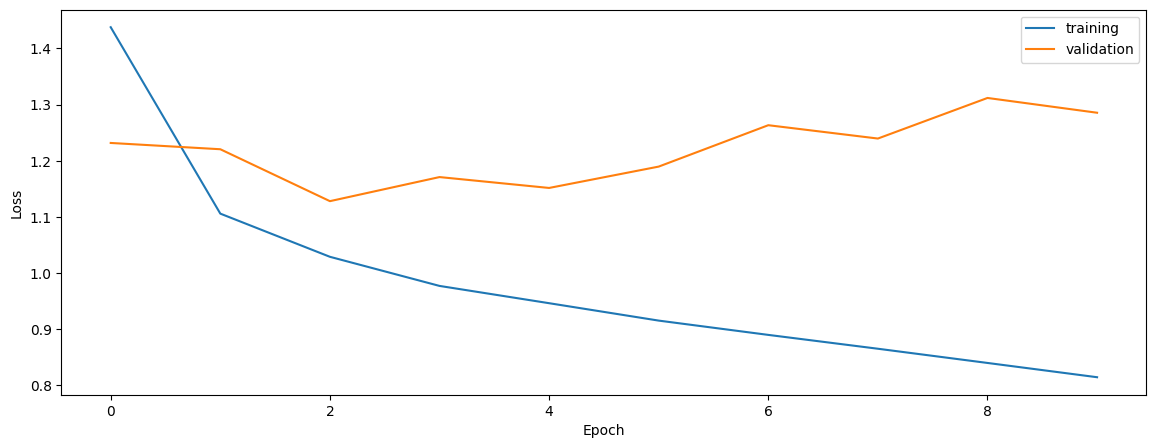

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6155863264394079
0.5535048890392018
0.5743062772904466


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5778578428664666
0.5639882832691976
0.5410859499182197


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5792968160555304
0.5596696097977784
0.5421273351124667


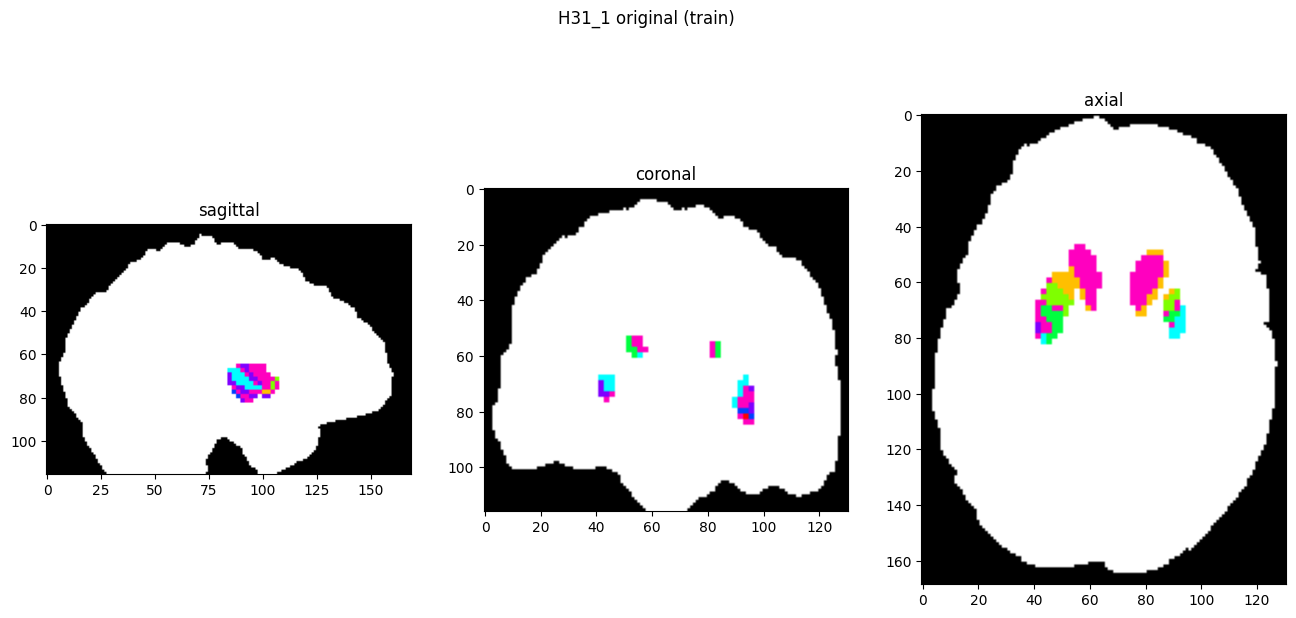

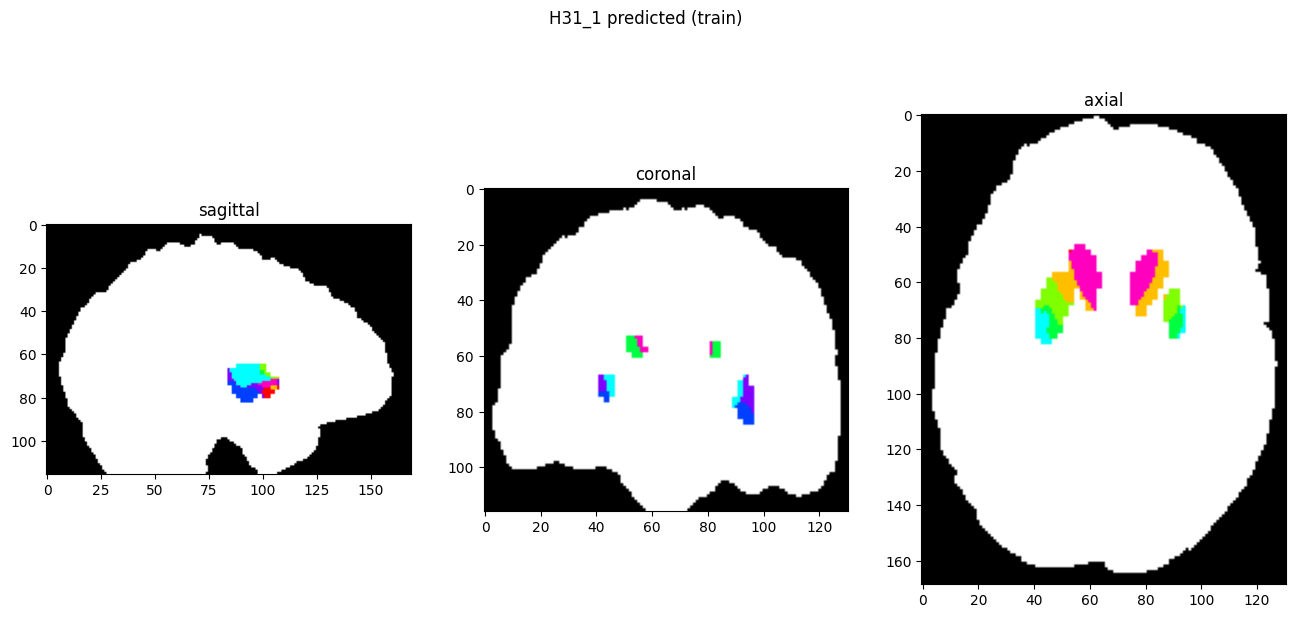

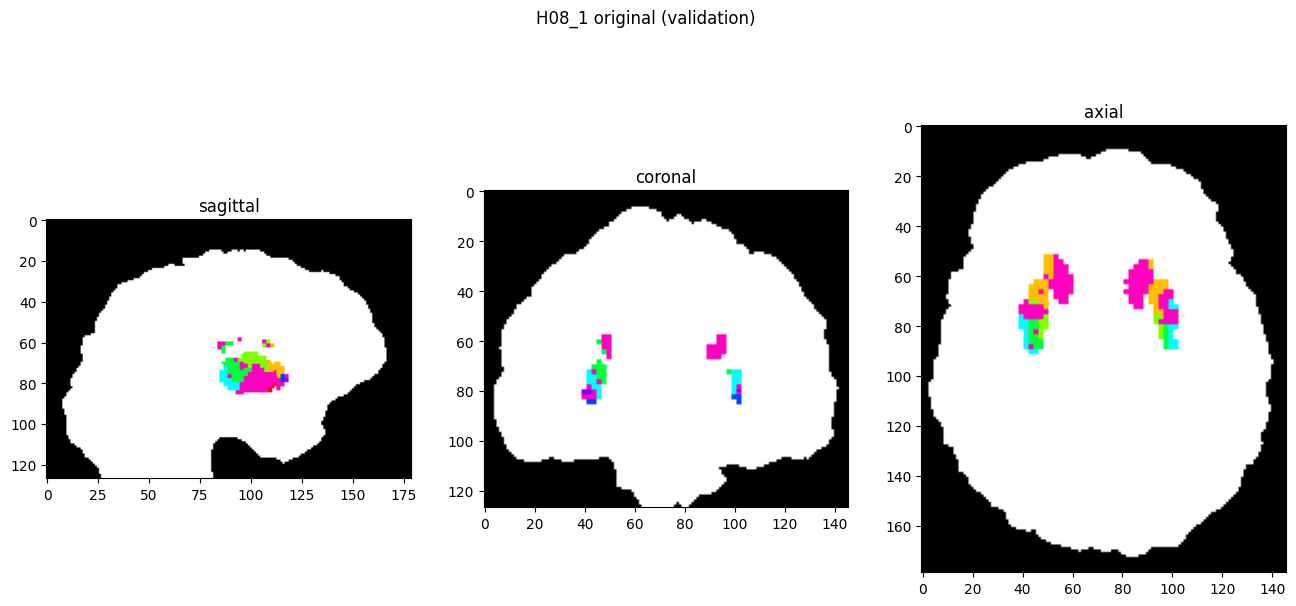

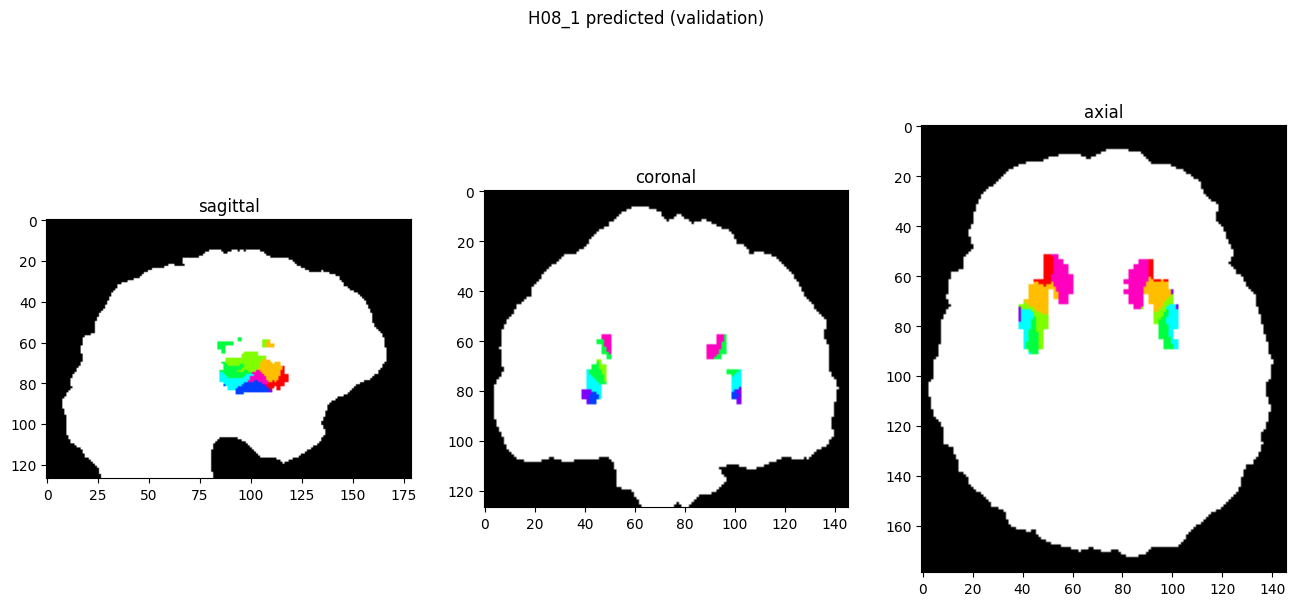

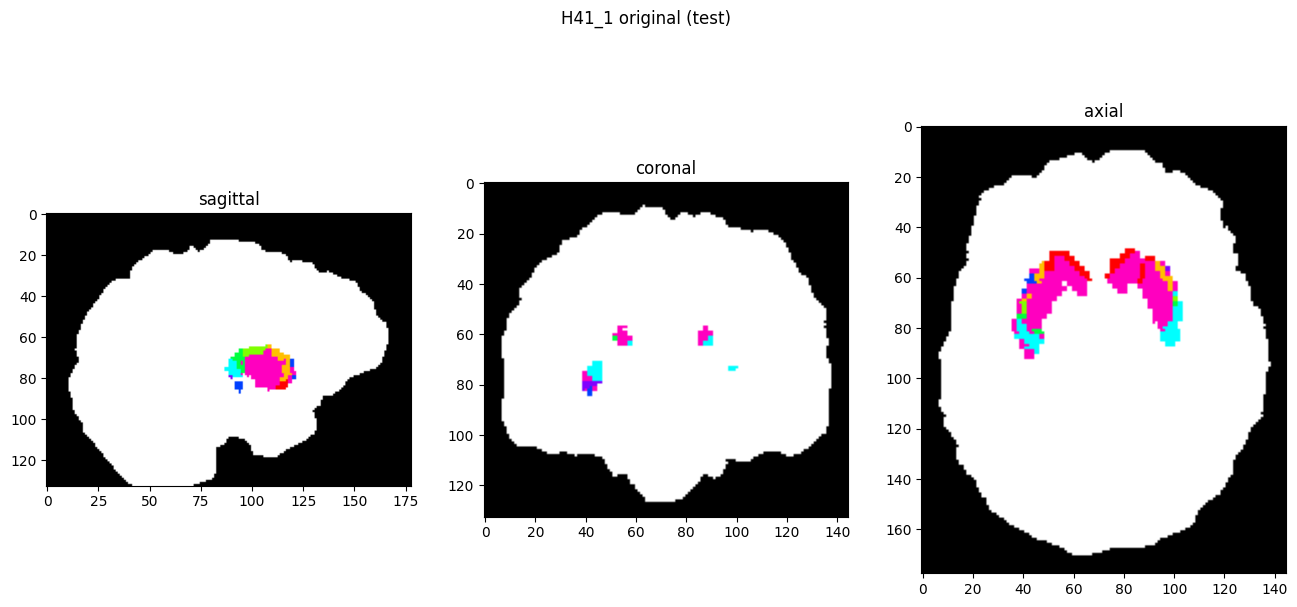

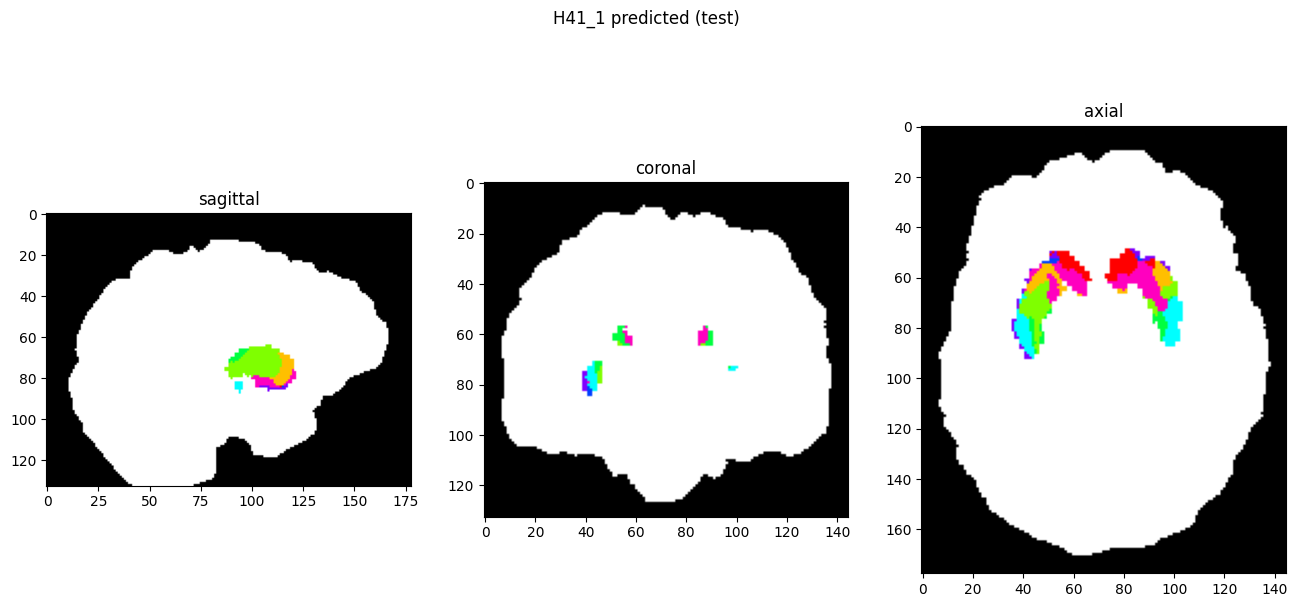

In [10]:
showResults(model, gen, threshold=0)